In [1]:
#ensembling
from mlxtend.classifier import StackingCVClassifier
import numpy as np
import pandas as pd
import sys, os, glob
import imp
import seaborn as sns
sys.path.append('./src/')
import common_utils,my_ensembler, feature_utils, defines, model_utils, my_bert
from sklearn.neighbors import KNeighborsClassifier
from sklearn_crfsuite import scorers, CRF
from sklearn.pipeline import Pipeline
import json
from operator import itemgetter
from sklearn_crfsuite.utils import flatten
from sklearn_crfsuite.metrics import sequence_accuracy_score
from sklearn.linear_model import LogisticRegression
import scipy
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
import classes
import pickle
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import re

In [2]:
dir_name='duplicate'
seq_len=15
step=15
cv_split_name='cv_splits_per_client'
merged_str='scaled.binary0.50_merged'
doc_indices=np.arange(1,81)
final_name='bert.crf.svc.per.client'
doc_indices
test_doc_num=8
seed=42

In [13]:
# crf_feat_name='crf.per.client.features'
# crf_feat_name='crf.per.client.features.no.lemma'
crf_feat_name="new.crf.features"

In [4]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

### Separate lexical  & non-lexical features

In [17]:
imp.reload(common_utils)
crf_cv_features=common_utils.load_db(dir_name,crf_feat_name)

Opened /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/new.crf.features.csv,  index None


In [18]:
crf_cv_features

,Unnamed: 0,weight_1,label,attr,string_1,weight_2,string_2,weight_3,string_3,weight_4,string_4,weight_5,string_5,weight_6,string_6,weight_7,string_7,weight,string,mean
0,0,5.40557,not_nar,tfidf_word_5097,שלם,5.88427,שלם,0.26539,שלם,5.91796,שלם,5.13129,שלם,4.93516,שלם,4.44063,שלם,4.27396,שלם,4.53178
1,1,4.46727,not_nar,tfidf_word_1227,החלטה,4.44875,החלטה,4.37434,החלטה,5.18344,החלטה,4.10170,החלטה,3.73883,החלטה,2.23783,החלטה,3.52003,החלטה,4.00903
2,2,3.99349,is_nar,tfidf_char_wb_27937,פתי,3.85822,פתי,6.73314,פתי,1.61136,פתי,4.73830,פתי,4.61773,פתי,5.46384,פתי,1.95155,פתי,4.12095
3,3,3.89625,is_nar,tfidf_char_wb_4165,כת,0.00092,כת,-0.00079,כת,0.00000,כת,0.00019,כת,0.00042,כת,0.00000,NaN,0.00112,כת,0.48726
4,4,3.67707,not_nar,tfidf_word_2837,להשאר,2.21053,להשאר,1.51400,להשאר,2.72813,להשאר,3.33476,להשאר,0.00000,NaN,1.23814,להשאר,2.36491,להשאר,2.13344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10613,10613,0.00000,is_nar,tfidf_char_wb_12957,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,-0.00958,החי,-0.00120
10614,10614,0.00000,is_nar,tfidf_word_2788,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,-0.01219,להמשיך,-0.00152
10615,10615,0.00000,not_nar,tfidf_word_848,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,-0.05887,בתפקיד,-0.00736
10616,10616,0.00000,not_nar,tfidf_char_wb_16089,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,-0.08066,ומס,-0.01008


In [19]:
crf_cv_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10618 entries, 0 to 10617
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  10618 non-null  int64  
 1   weight_1    10618 non-null  float64
 2   label       10618 non-null  object 
 3   attr        10618 non-null  object 
 4   string_1    5190 non-null   object 
 5   weight_2    10618 non-null  float64
 6   string_2    6236 non-null   object 
 7   weight_3    10618 non-null  float64
 8   string_3    8006 non-null   object 
 9   weight_4    10618 non-null  float64
 10  string_4    6589 non-null   object 
 11  weight_5    10618 non-null  float64
 12  string_5    5992 non-null   object 
 13  weight_6    10618 non-null  float64
 14  string_6    5845 non-null   object 
 15  weight_7    10618 non-null  float64
 16  string_7    5665 non-null   object 
 17  weight      10618 non-null  float64
 18  string      9809 non-null   object 
 19  mean        10618 non-nul

In [20]:
crf_cv_features.shape[0]

10618

In [21]:
crf_cv_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10618 entries, 0 to 10617
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  10618 non-null  int64  
 1   weight_1    10618 non-null  float64
 2   label       10618 non-null  object 
 3   attr        10618 non-null  object 
 4   string_1    5190 non-null   object 
 5   weight_2    10618 non-null  float64
 6   string_2    6236 non-null   object 
 7   weight_3    10618 non-null  float64
 8   string_3    8006 non-null   object 
 9   weight_4    10618 non-null  float64
 10  string_4    6589 non-null   object 
 11  weight_5    10618 non-null  float64
 12  string_5    5992 non-null   object 
 13  weight_6    10618 non-null  float64
 14  string_6    5845 non-null   object 
 15  weight_7    10618 non-null  float64
 16  string_7    5665 non-null   object 
 17  weight      10618 non-null  float64
 18  string      9809 non-null   object 
 19  mean        10618 non-nul

In [22]:
# del crf_cv_features

In [23]:
tf_f_num=crf_cv_features[crf_cv_features['attr'].str.contains('tfidf')].shape[0]
print(tf_f_num,tf_f_num/crf_cv_features.shape[0])

9809 0.9238086268600489


In [24]:
neighbor_f_num=crf_cv_features[crf_cv_features['attr'].str.contains("\+|\-")].shape[0]
print(neighbor_f_num,neighbor_f_num*100/(crf_cv_features.shape[0]-tf_f_num))

696 86.03213844252163


In [25]:
nar_pos=crf_cv_features[(crf_cv_features['label']=='is_nar')&(crf_cv_features['mean']>0)][['mean','attr','string']].sort_values(by='mean',ascending=False).reset_index(drop=True).copy()
nar_neg=crf_cv_features[(crf_cv_features['label']=='is_nar')&(crf_cv_features['mean']<0)][['mean','attr','string']].sort_values(by='mean',ascending=True).reset_index(drop=True).copy()

In [26]:
nar_neg

,mean,attr,string
0,-1.12152,tfidf_char_wb_8820,אות
1,-1.01061,tfidf_char_wb_7302,ש
2,-0.84527,tfidf_word_3954,מתי
3,-0.80848,tfidf_word_492,בחיים
4,-0.76959,+3:POSTAG_CDT,NaN
...,...,...,...
1567,-0.00000,tfidf_char_wb_14348,השי
1568,-0.00000,tfidf_char_wb_7571,שום
1569,-0.00000,tfidf_char_wb_7572,שום
1570,-0.00000,tfidf_char_wb_5089,מבין


### Meta-features

In [454]:
crf_cv_features[(~crf_cv_features['attr'].str.contains('tfidf'))&(crf_cv_features['label']=='is_nar')]['mean'].describe()

count   400.00000
mean     -0.01241
std       0.09604
min      -0.76959
25%      -0.02428
50%      -0.00196
75%       0.00810
max       0.48786
Name: mean, dtype: float64

In [455]:
crf_cv_features[(crf_cv_features['attr'].str.contains('tfidf'))&(crf_cv_features['label']=='is_nar')]['mean'].describe()

count   3455.00000
mean       0.05883
std        0.24219
min       -1.12152
25%       -0.00108
50%        0.00048
75%        0.03155
max        4.12095
Name: mean, dtype: float64

In [456]:
nar_pos_meta=nar_pos[~nar_pos['attr'].str.contains('tfidf')].copy()
nar_neg_meta=nar_neg[~nar_neg['attr'].str.contains('tfidf')].copy()

In [457]:
pos_threshold=np.percentile(nar_pos_meta['mean'],95)
pos_threshold

0.1325104999999999

In [458]:
neg_threshold=np.percentile(nar_neg_meta['mean'],5)
neg_threshold

-0.202144

In [459]:
nar_pos_meta=nar_pos_meta[nar_pos_meta['mean']>=pos_threshold]

In [460]:
nar_pos_meta

,mean,attr,string
142,0.48786,f_num_D,NaN
152,0.45973,+1:f_per_2,NaN
194,0.38775,-1:POSTAG_INTJ,NaN
286,0.25765,f_tense_PAST,NaN
322,0.22143,+2:POSTAG_DT,NaN
332,0.21340,is_client,NaN
398,0.17113,sent_len,NaN
400,0.16945,-1:f_suf_per_1.0,NaN
477,0.13301,+1:is_question,NaN


In [461]:
nar_pos_meta.shape[0],nar_neg_meta.shape[0]

(9, 235)

In [462]:
nar_neg_meta=nar_neg_meta[nar_neg_meta['mean']<neg_threshold]
nar_neg_meta.sort_values(by='mean',inplace=True,ascending=False)
nar_neg_meta

,mean,attr,string
70,-0.21382,+2:POSTAG_DTT,NaN
65,-0.23334,POSTAG_INTJ,NaN
61,-0.24379,-2:f_suf_per_2.0,NaN
58,-0.25101,+1:POSTAG_COP,NaN
57,-0.25111,+3:POSTAG_CD,NaN
54,-0.25799,+2:POSTAG_CDT,NaN
44,-0.29258,+2:f_tense_IMPERATIVE,NaN
35,-0.35660,f_per_2,NaN
14,-0.54789,+3:f_tense_IMPERATIVE,NaN
13,-0.56155,+1:POSTAG_CDT,NaN


In [463]:
nar_meta=pd.concat([nar_pos_meta,nar_neg_meta],axis=0).drop('string',axis=1) #,ignore_index=True)
nar_meta.reset_index(inplace=True)
nar_meta.rename({'index':'rank'},axis=1,inplace=True)
nar_meta

,rank,mean,attr
0,142,0.48786,f_num_D
1,152,0.45973,+1:f_per_2
2,194,0.38775,-1:POSTAG_INTJ
3,286,0.25765,f_tense_PAST
4,322,0.22143,+2:POSTAG_DT
5,332,0.21340,is_client
6,398,0.17113,sent_len
7,400,0.16945,-1:f_suf_per_1.0
8,477,0.13301,+1:is_question
9,70,-0.21382,+2:POSTAG_DTT


In [464]:
nar_meta['prefix']=nar_meta['attr'].astype(str).str[:3]
nar_meta

,rank,mean,attr,prefix
0,142,0.48786,f_num_D,f_n
1,152,0.45973,+1:f_per_2,+1:
2,194,0.38775,-1:POSTAG_INTJ,-1:
3,286,0.25765,f_tense_PAST,f_t
4,322,0.22143,+2:POSTAG_DT,+2:
5,332,0.21340,is_client,is_
6,398,0.17113,sent_len,sen
7,400,0.16945,-1:f_suf_per_1.0,-1:
8,477,0.13301,+1:is_question,+1:
9,70,-0.21382,+2:POSTAG_DTT,+2:


In [465]:
nar_meta['prefix'].str.contains("\-1",na=False)

0     False
1     False
2      True
3     False
4     False
5     False
6     False
7      True
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
Name: prefix, dtype: bool

In [466]:
meta_names = {
    'f_per_2':'second person',
    'INTJ': 'interjection',
    'len': 'length (char)',
    'PAST':'past tense',
    'is_client':'is client',
    'num_D':'dual number',
    'TOKEN':'length (words)',
    'is_question':'is question',
    'NNP':'proper noun',
    'suf_gen_F':'female suffix',
    'IMPERATIVE':'imperative tense',
    '_CDT': 'numeral determiner',
    '_CD':'numeral, cardinal',
    '_COP': 'auxiliary verb',
    'num_P':'plural',
    '_DTT':'definite article',
    'FUTURE':'future tense',
    'BEINONI':'neuter verb',
    '_JJT':'definite constant adverb',
    'sent_pos_in_par':'position in paragraph',
    '_EX':'existential verb'
}

In [467]:
def translate_feature(x):
    translation = ''
    prefix=''
    if ':' in x:
        spl=x.split(':')
        prefix=spl[0]
        feature=spl[1]
    else:
        feature = x
    for k,v in meta_names.items():
        if k in feature:
            translation = v
            break
    return ' '.join([prefix,translation]) 

In [468]:

nar_meta['prefix']=nar_meta['attr'].astype(str).str[:3]
nar_meta.loc[nar_meta['prefix'].str.contains(r"\-3",na=False),'order']=0
nar_meta.loc[nar_meta['prefix'].str.contains(r"\-2",na=False),'order']=1
nar_meta.loc[nar_meta['prefix'].str.contains(r"\-1",na=False),'order']=2
nar_meta.loc[~nar_meta['prefix'].str.contains(r"\+|\-",na=False),'order']=3
nar_meta.loc[nar_meta['prefix'].str.contains(r"\+1",na=False),'order']=4
nar_meta.loc[nar_meta['prefix'].str.contains(r"\+2",na=False),'order']=5
nar_meta.loc[nar_meta['prefix'].str.contains(r"\+3",na=False),'order']=6
nar_meta.sort_values(by=['order','mean'],inplace=True)

In [469]:
nar_meta['name']=nar_meta['attr'].apply(translate_feature)
nar_meta

,rank,mean,attr,prefix,order,name
11,61,-0.24379,-2:f_suf_per_2.0,-2:,1.00000,-2 second person
7,400,0.16945,-1:f_suf_per_1.0,-1:,2.00000,-1
2,194,0.38775,-1:POSTAG_INTJ,-1:,2.00000,-1 interjection
16,35,-0.35660,f_per_2,f_p,3.00000,second person
10,65,-0.23334,POSTAG_INTJ,POS,3.00000,interjection
6,398,0.17113,sent_len,sen,3.00000,length (char)
5,332,0.21340,is_client,is_,3.00000,is client
3,286,0.25765,f_tense_PAST,f_t,3.00000,past tense
0,142,0.48786,f_num_D,f_n,3.00000,dual number
19,7,-0.72151,+1:f_suf_num_P,+1:,4.00000,+1 plural


In [470]:
nar_meta.sort_values(by=['order','mean'],ascending=False,inplace=True)

In [471]:
nar_meta.index.tolist()

[13, 17, 20, 4, 9, 14, 15, 1, 8, 12, 18, 19, 0, 3, 5, 6, 10, 16, 2, 7, 11]

In [472]:
common_utils.save_db(nar_meta,dir_name,"nar_meta_order",True)

Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/nar_meta_order.csv, 
index True
float_format %.5f


In [473]:
nar_meta.to_csv(sep=' ')

' rank mean attr prefix order name\n13 57 -0.25111 +3:POSTAG_CD +3: 6.0 "+3 numeral, cardinal"\n17 14 -0.54789 +3:f_tense_IMPERATIVE +3: 6.0 "+3 imperative tense"\n20 4 -0.76959 +3:POSTAG_CDT +3: 6.0 "+3 numeral determiner"\n4 322 0.22143 +2:POSTAG_DT +2: 5.0 "+2 "\n9 70 -0.21382 +2:POSTAG_DTT +2: 5.0 "+2 definite article"\n14 54 -0.25799 +2:POSTAG_CDT +2: 5.0 "+2 numeral determiner"\n15 44 -0.29258 +2:f_tense_IMPERATIVE +2: 5.0 "+2 imperative tense"\n1 152 0.45973 +1:f_per_2 +1: 4.0 "+1 second person"\n8 477 0.13301 +1:is_question +1: 4.0 "+1 is question"\n12 58 -0.25101 +1:POSTAG_COP +1: 4.0 "+1 auxiliary verb"\n18 13 -0.56155 +1:POSTAG_CDT +1: 4.0 "+1 numeral determiner"\n19 7 -0.72151 +1:f_suf_num_P +1: 4.0 "+1 plural"\n0 142 0.48786 f_num_D f_n 3.0 " dual number"\n3 286 0.25765 f_tense_PAST f_t 3.0 " past tense"\n5 332 0.2134 is_client is_ 3.0 " is client"\n6 398 0.17113 sent_len sen 3.0 " length (char)"\n10 65 -0.23334 POSTAG_INTJ POS 3.0 " interjection"\n16 35 -0.3566 f_per_2 f_

In [474]:
nn_pos=crf_cv_features[(crf_cv_features['label']=='not_nar')&(crf_cv_features['mean']>0)][['mean','attr','string']].sort_values(by='mean',ascending=False).reset_index(drop=True).copy()
nn_neg=crf_cv_features[(crf_cv_features['label']=='not_nar')&(crf_cv_features['mean']<0)][['mean','attr','string']].sort_values(by='mean',ascending=True).reset_index(drop=True).copy()

In [475]:
nn_pos_meta=nn_pos[~nn_pos['attr'].str.contains('tfidf')].copy()
nn_neg_meta=nn_neg[~nn_neg['attr'].str.contains('tfidf')].copy()

In [476]:
pos_nn_threshold=np.percentile(nn_pos_meta['mean'],95)
pos_nn_threshold

0.21382

In [477]:
neg_nn_threshold=np.percentile(nn_neg_meta['mean'],5)
neg_nn_threshold

-0.170794

In [478]:
nn_pos_meta=nn_pos_meta[nn_pos_meta['mean']>=pos_threshold]
nn_pos_meta

,mean,attr,string
119,0.92118,-2:f_suf_per_2.0,NaN
147,0.76959,+3:POSTAG_CDT,NaN
157,0.72151,+1:f_suf_num_P,NaN
201,0.56155,+1:POSTAG_CDT,NaN
209,0.54789,+3:f_tense_IMPERATIVE,NaN
283,0.35660,f_per_2,NaN
325,0.29258,+2:f_tense_IMPERATIVE,NaN
358,0.25799,+2:POSTAG_CDT,NaN
362,0.25111,+3:POSTAG_CD,NaN
363,0.25101,+1:POSTAG_COP,NaN


In [479]:
nn_neg_meta=nn_neg_meta[nn_neg_meta['mean']<neg_threshold]
nn_neg_meta.sort_values(by='mean',inplace=True,ascending=False)
nn_neg_meta

,mean,attr,string
401,-0.21340,is_client,NaN
389,-0.22143,+2:POSTAG_DT,NaN
357,-0.25765,f_tense_PAST,NaN
268,-0.34919,+2:POSTAG_JJT,NaN
243,-0.38775,-1:POSTAG_INTJ,NaN
186,-0.45973,+1:f_per_2,NaN
173,-0.48786,f_num_D,NaN
72,-0.79527,+3:POSTAG_JJT,NaN


In [480]:
nn_meta=pd.concat([nn_pos_meta,nn_neg_meta],axis=0).drop('string',axis=1) #,ignore_index=True)
nn_meta.reset_index(inplace=True)
nn_meta.rename({'index':'rank'},axis=1,inplace=True)
nn_meta

,rank,mean,attr
0,119,0.92118,-2:f_suf_per_2.0
1,147,0.76959,+3:POSTAG_CDT
2,157,0.72151,+1:f_suf_num_P
3,201,0.56155,+1:POSTAG_CDT
4,209,0.54789,+3:f_tense_IMPERATIVE
5,283,0.35660,f_per_2
6,325,0.29258,+2:f_tense_IMPERATIVE
7,358,0.25799,+2:POSTAG_CDT
8,362,0.25111,+3:POSTAG_CD
9,363,0.25101,+1:POSTAG_COP


In [481]:
nn_meta['name']=nn_meta['attr'].apply(translate_feature)
nn_meta

,rank,mean,attr,name
0,119,0.92118,-2:f_suf_per_2.0,-2 second person
1,147,0.76959,+3:POSTAG_CDT,+3 numeral determiner
2,157,0.72151,+1:f_suf_num_P,+1 plural
3,201,0.56155,+1:POSTAG_CDT,+1 numeral determiner
4,209,0.54789,+3:f_tense_IMPERATIVE,+3 imperative tense
5,283,0.35660,f_per_2,second person
6,325,0.29258,+2:f_tense_IMPERATIVE,+2 imperative tense
7,358,0.25799,+2:POSTAG_CDT,+2 numeral determiner
8,362,0.25111,+3:POSTAG_CD,"+3 numeral, cardinal"
9,363,0.25101,+1:POSTAG_COP,+1 auxiliary verb


In [482]:
nn_meta=common_utils.order_meta_features(nn_meta)
nn_meta

,rank,mean,attr,name,prefix,order
1,147,0.76959,+3:POSTAG_CDT,+3 numeral determiner,+3:,6.00000
4,209,0.54789,+3:f_tense_IMPERATIVE,+3 imperative tense,+3:,6.00000
8,362,0.25111,+3:POSTAG_CD,"+3 numeral, cardinal",+3:,6.00000
25,72,-0.79527,+3:POSTAG_JJT,+3 definite constant adverb,+3:,6.00000
6,325,0.29258,+2:f_tense_IMPERATIVE,+2 imperative tense,+2:,5.00000
7,358,0.25799,+2:POSTAG_CDT,+2 numeral determiner,+2:,5.00000
12,407,0.21382,+2:POSTAG_DTT,+2 definite article,+2:,5.00000
19,389,-0.22143,+2:POSTAG_DT,+2,+2:,5.00000
21,268,-0.34919,+2:POSTAG_JJT,+2 definite constant adverb,+2:,5.00000
2,157,0.72151,+1:f_suf_num_P,+1 plural,+1:,4.00000


In [483]:
common_utils.save_db(nn_meta,dir_name,'nn_meta_order')

Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/nn_meta_order.csv, 
index False
float_format %.5f


# Get tfidf features for narrative

In [484]:
# crf_cv_features=common_utils.load_db(dir_name,'crf.features.new.30.no.71')

In [27]:
nar_tf=crf_cv_features.copy().sort_values(by='mean',ascending=False)#[(crf_cv_features['label']=='is_nar')&(crf_cv_features['attr'].str.contains('tfidf'))][['mean','attr','string','label']].sort_values(by='mean',ascending=False).reset_index(drop=True).copy()
nar_tf

,Unnamed: 0,weight_1,label,attr,string_1,weight_2,string_2,weight_3,string_3,weight_4,string_4,weight_5,string_5,weight_6,string_6,weight_7,string_7,weight,string,mean
0,0,5.40557,not_nar,tfidf_word_5097,שלם,5.88427,שלם,0.26539,שלם,5.91796,שלם,5.13129,שלם,4.93516,שלם,4.44063,שלם,4.27396,שלם,4.53178
2,2,3.99349,is_nar,tfidf_char_wb_27937,פתי,3.85822,פתי,6.73314,פתי,1.61136,פתי,4.73830,פתי,4.61773,פתי,5.46384,פתי,1.95155,פתי,4.12095
1,1,4.46727,not_nar,tfidf_word_1227,החלטה,4.44875,החלטה,4.37434,החלטה,5.18344,החלטה,4.10170,החלטה,3.73883,החלטה,2.23783,החלטה,3.52003,החלטה,4.00903
6,6,3.46886,not_nar,tfidf_char_wb_13437,המט,1.11455,המט,2.00408,המט,2.59828,המט,4.98409,המט,3.77617,המט,4.85587,המט,5.53057,המט,3.54156
80,80,1.83723,not_nar,tfidf_word_3065,לסיים,3.29905,לסיים,2.92348,לסיים,3.30618,לסיים,3.49788,לסיים,2.73990,לסיים,3.97579,לסיים,3.45717,לסיים,3.12959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5928,5928,-1.51628,not_nar,tfidf_char_wb_19654,יס,-1.82522,יס,-3.45547,יס,-1.92724,יס,-1.76508,יס,-2.44106,יס,-2.68091,יס,-1.73279,יס,-2.16801
4171,4171,-0.00326,not_nar,tfidf_char_wb_32753,תרו,-4.44433,תרו,-2.64221,תרו,-0.71552,תרו,-2.88836,תרו,-2.15347,תרו,-3.57549,תרו,-3.41314,תרו,-2.47947
5954,5954,-2.08611,not_nar,tfidf_char_wb_16268,וסי,-0.44875,וסי,-4.66189,וסי,-3.20829,וסי,-2.84010,וסי,-5.57362,וסי,0.00000,NaN,-1.40735,וסי,-2.52826
5959,5959,-2.69456,not_nar,tfidf_char_wb_30781,שיר,-3.14390,שיר,-3.36071,שיר,-3.66207,שיר,-2.84501,שיר,-2.74760,שיר,-2.25062,שיר,-2.82667,שיר,-2.94139


In [28]:
nar_tf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10618 entries, 0 to 7924
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  10618 non-null  int64  
 1   weight_1    10618 non-null  float64
 2   label       10618 non-null  object 
 3   attr        10618 non-null  object 
 4   string_1    5190 non-null   object 
 5   weight_2    10618 non-null  float64
 6   string_2    6236 non-null   object 
 7   weight_3    10618 non-null  float64
 8   string_3    8006 non-null   object 
 9   weight_4    10618 non-null  float64
 10  string_4    6589 non-null   object 
 11  weight_5    10618 non-null  float64
 12  string_5    5992 non-null   object 
 13  weight_6    10618 non-null  float64
 14  string_6    5845 non-null   object 
 15  weight_7    10618 non-null  float64
 16  string_7    5665 non-null   object 
 17  weight      10618 non-null  float64
 18  string      9809 non-null   object 
 19  mean        10618 non-null

In [444]:
nar_tf.loc[(nar_tf['string']=='ישיבה')&(nar_tf['label']=='is_nar')&(nar_tf['attr'].str.contains('word')),:]

,weight_1,label,attr,string_1,weight_2,string_2,weight_3,string_3,weight_4,string_4,weight_5,string_5,weight_6,string_6,weight_7,string_7,weight,string,mean
7910,0.00000,is_nar,tfidf_word_2479,NaN,-1.14662,ישיבה,-0.01730,ישיבה,-0.17326,ישיבה,-0.17344,ישיבה,-0.86918,ישיבה,-1.02721,ישיבה,-0.04719,ישיבה,-0.43178


In [437]:
nar_tf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10618 entries, 0 to 7924
Data columns (total 19 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   weight_1  10618 non-null  float64
 1   label     10618 non-null  object 
 2   attr      10618 non-null  object 
 3   string_1  5190 non-null   object 
 4   weight_2  10618 non-null  float64
 5   string_2  6236 non-null   object 
 6   weight_3  10618 non-null  float64
 7   string_3  8006 non-null   object 
 8   weight_4  10618 non-null  float64
 9   string_4  6589 non-null   object 
 10  weight_5  10618 non-null  float64
 11  string_5  5992 non-null   object 
 12  weight_6  10618 non-null  float64
 13  string_6  5845 non-null   object 
 14  weight_7  10618 non-null  float64
 15  string_7  5665 non-null   object 
 16  weight    10618 non-null  float64
 17  string    9809 non-null   object 
 18  mean      10618 non-null  float64
dtypes: float64(9), object(10)
memory usage: 1.6+ MB


In [30]:
limit=15

In [32]:
import re
def wrap_heb_String(x):
    if ' ' in x:
        x=re.sub(' ','\_',x)
    return '\myHeb{'+x+'}'

In [39]:
top_plot=pd.DataFrame()
dow_plot=pd.DataFrame()
top_local_plot=pd.DataFrame()
dow_local_plot=pd.DataFrame()
tf_types=['char','lemma','word']
tf_types=['char','word']

for attr_type in tf_types:
    for label in ['is_nar','not_nar']:
        slice_df=nar_tf[(nar_tf['label'] == label)&(nar_tf['attr'].str.contains(attr_type))].head(limit)
        top_plot['weight.{}.{}'.format(attr_type,label)]=slice_df['mean'].tolist()
        top_plot['string.{}.{}'.format(attr_type,label)]=slice_df['string'].apply(wrap_heb_String).tolist()
  
        top_local_plot['weight.{}.{}'.format(attr_type,label)]=slice_df['mean'].tolist()
        top_local_plot['string.{}.{}'.format(attr_type,label)]=slice_df['string'].tolist()
        
#         slice_df=nar_tf[(nar_tf['label'] == label)&(nar_tf['attr'].str.contains(attr_type))].tail(limit)
        
#         dow_plot['weight.{}.{}'.format(attr_type,label)]=slice_df['mean'].tolist()
#         dow_plot['string.{}.{}'.format(attr_type,label)]=slice_df['string'].apply(wrap_heb_String).tolist()
        
#         dow_local_plot['weight.{}.{}'.format(attr_type,label)]=slice_df['mean'].tolist()
#         dow_local_plot['string.{}.{}'.format(attr_type,label)]=slice_df['string'].tolist()
        
# features_plot=pd.concat([top_plot,dow_plot]).reset_index()
features_plot=top_plot
# local_plot=pd.concat([top_local_plot,dow_local_plot]).reset_index()
local_plot=top_local_plot
features_plot

,weight.char.is_nar,string.char.is_nar,weight.char.not_nar,string.char.not_nar,weight.word.is_nar,string.word.is_nar,weight.word.not_nar,string.word.not_nar
0,4.12095,\myHeb{פתי},3.54156,\myHeb{המט},2.77814,\myHeb{דירה},4.53178,\myHeb{שלם}
1,2.94139,\myHeb{שיר},2.29206,\myHeb{\_המט},2.52149,\myHeb{פעולה},4.00903,\myHeb{החלטה}
2,2.20780,\myHeb{עברת},2.01810,\myHeb{חיר},2.43788,\myHeb{תקשיבי},3.12959,\myHeb{לסיים}
3,1.83289,\myHeb{יס\_},1.97288,\myHeb{רגיע},2.38688,\myHeb{בפייסבוק},3.04043,\myHeb{לצחוק}
4,1.75457,\myHeb{ביר},1.64224,\myHeb{יכנ},2.07101,\myHeb{ביקורת},2.76978,\myHeb{שלומך}
5,1.56284,\myHeb{\_התקש},1.55640,\myHeb{אבק},1.96129,\myHeb{ביקשתי},2.73607,\myHeb{בהקשר}
6,1.49316,\myHeb{ניה},1.28618,\myHeb{עוצ},1.84720,\myHeb{מספרת},2.58778,\myHeb{מהעבר}
7,1.30949,\myHeb{לחת},1.25159,\myHeb{מלא\_},1.78733,\myHeb{יושבים},2.57766,\myHeb{שאמרת}
8,1.27508,\myHeb{שלח},1.19254,\myHeb{\_הגב},1.76237,\myHeb{הודעה},2.55117,\myHeb{קיבלת}
9,1.19351,\myHeb{\_חר},1.14398,\myHeb{להרג},1.76124,\myHeb{שלח},2.53428,\myHeb{ואחר}


In [35]:
features_plot

,weight.char.is_nar,string.char.is_nar,weight.char.not_nar,string.char.not_nar,weight.word.is_nar,string.word.is_nar,weight.word.not_nar,string.word.not_nar
0,4.12095,\myHeb{פתי},3.54156,\myHeb{המט},2.77814,\myHeb{דירה},4.53178,\myHeb{שלם}
1,2.94139,\myHeb{שיר},2.29206,\myHeb{\_המט},2.52149,\myHeb{פעולה},4.00903,\myHeb{החלטה}
2,2.20780,\myHeb{עברת},2.01810,\myHeb{חיר},2.43788,\myHeb{תקשיבי},3.12959,\myHeb{לסיים}
3,1.83289,\myHeb{יס\_},1.97288,\myHeb{רגיע},2.38688,\myHeb{בפייסבוק},3.04043,\myHeb{לצחוק}
4,1.75457,\myHeb{ביר},1.64224,\myHeb{יכנ},2.07101,\myHeb{ביקורת},2.76978,\myHeb{שלומך}
5,1.56284,\myHeb{\_התקש},1.55640,\myHeb{אבק},1.96129,\myHeb{ביקשתי},2.73607,\myHeb{בהקשר}
6,1.49316,\myHeb{ניה},1.28618,\myHeb{עוצ},1.84720,\myHeb{מספרת},2.58778,\myHeb{מהעבר}
7,1.30949,\myHeb{לחת},1.25159,\myHeb{מלא\_},1.78733,\myHeb{יושבים},2.57766,\myHeb{שאמרת}
8,1.27508,\myHeb{שלח},1.19254,\myHeb{\_הגב},1.76237,\myHeb{הודעה},2.55117,\myHeb{קיבלת}
9,1.19351,\myHeb{\_חר},1.14398,\myHeb{להרג},1.76124,\myHeb{שלח},2.53428,\myHeb{ואחר}


In [36]:
common_utils.save_db(features_plot,dir_name,'tf.features.plot')

Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/tf.features.plot.csv, 
index False
float_format %.5f


## Plot features

In [37]:
local_plot

,weight.char.is_nar,string.char.is_nar,weight.char.not_nar,string.char.not_nar,weight.word.is_nar,string.word.is_nar,weight.word.not_nar,string.word.not_nar
0,4.12095,פתי,3.54156,המט,2.77814,דירה,4.53178,שלם
1,2.94139,שיר,2.29206,המט,2.52149,פעולה,4.00903,החלטה
2,2.20780,עברת,2.01810,חיר,2.43788,תקשיבי,3.12959,לסיים
3,1.83289,יס,1.97288,רגיע,2.38688,בפייסבוק,3.04043,לצחוק
4,1.75457,ביר,1.64224,יכנ,2.07101,ביקורת,2.76978,שלומך
5,1.56284,התקש,1.55640,אבק,1.96129,ביקשתי,2.73607,בהקשר
6,1.49316,ניה,1.28618,עוצ,1.84720,מספרת,2.58778,מהעבר
7,1.30949,לחת,1.25159,מלא,1.78733,יושבים,2.57766,שאמרת
8,1.27508,שלח,1.19254,הגב,1.76237,הודעה,2.55117,קיבלת
9,1.19351,חר,1.14398,להרג,1.76124,שלח,2.53428,ואחר


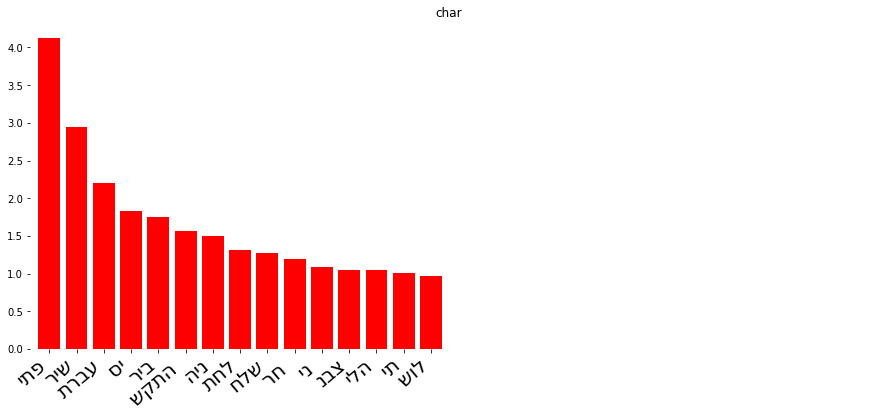

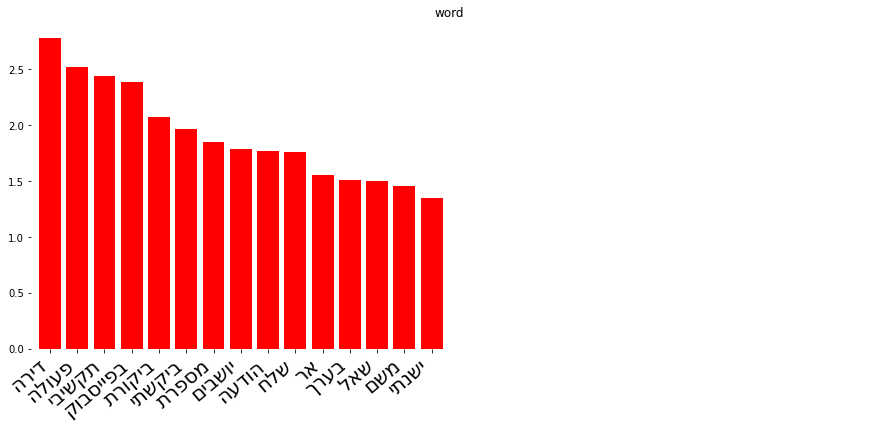

In [40]:
imp.reload(model_utils)
for tt in tf_types:
    plt.figure(figsize=(15, 6))
    ax=model_utils.plot_important_features(tt,local_plot['weight.{}.is_nar'.format(tt)].tolist(), local_plot['string.{}.is_nar'.format(tt)].tolist(), top_n=15, rotation=40)
    plt.show()

In [257]:
common_utils.save_db(local_plot,dir_name,'local.plot.tfidf')

Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/local.plot.tfidf.csv, 
index False
float_format %.5f


### Try different types of fixing

In [34]:
fix_options = {
    'sm.ssa':['single_miss','single_sa'],
    'dm.sm':['double_miss','single_miss'],
    'dm.sm.ssa':['double_miss,''single_miss','single_sa'],
    'sm.ssa.dm.dsa':['double_miss','single_miss','double_sa','single_sa'],
    'tm': ['tree_miss','single_sa'],
    'tm.dm.sm': ['tree_miss','double_miss','single_miss'],
    'tm.dm.sm.ssa':  ['tree_miss','double_miss','single_miss','single_sa'],
    'tm.dm.sm.one.neigh':  ['tree_miss','double_miss','single_miss'],
    'fm.tm.dm.sm.one.neigh':  ['four_miss','tree_miss','double_miss','single_miss'],
    'fm.tm.dm.sm.ssa.dsa.one.neigh':  ['four_miss','tree_miss','double_miss','single_miss','double_sa','single_sa'],
    'fm.tm.dm.sm.ssa':  ['four_miss','tree_miss','double_miss','single_miss','single_sa'],
    'sm.2':['loop_2'],
    'sm.3':['loop_3'],
    'sm.4':['loop_4'],
    'dm.shift': ['double_miss'],
    'sm.dm.shift': ['double_miss','single_miss'],
    'sm.dm.tm.shift': ['tree_miss','double_miss','single_miss'],
#     'sm.dm.tm.fm.shift': ['single_miss','double_miss','tree_miss','four_miss'],
#     'sm.dm.tm.fm.ssa': ['single_miss','double_miss','tree_miss','four_miss','single_sa'],
#     'sm.dm.tm.fm.ssa.dsa': ['single_miss','double_miss','tree_miss','four_miss','single_sa','double_sa'],
#     'order.ssa.sm.dm.tm.fm': ['single_sa','four_miss','tree_miss','double_miss','single_miss'],
    'fm.tm.dm.sm_4n': ['four_miss','tree_miss','double_miss','single_miss','single_sa'],
    'fm.tm.dm.ssa_4n.dsa_4n': ['four_miss','tree_miss','double_miss','single_miss','double_sa','single_sa']
}

In [56]:
run_options={}
run_options={
    'sm.ssa':['single_miss','single_sa'],

}

In [57]:
all_pred_crf01=common_utils.load_db(dir_name,final_name)

Opened /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/bert.crf.svc.per.client.csv,  index False


In [268]:
# imp.reload(classes)
# my_tables={}
# for  name,opt in run_options.items():
#     my_tables[name]=classes.MyScoreSummarizer(pred_df=all_pred_crf01,fix_list=opt)
#     my_tables[name].get_all_scores(unit='all')

In [60]:
my_tables[best_fix].print_df['ens']

,sent_f1,fixed_f1,sent_recall,fixed_recall,sent_prec,fixed_prec
0,0.87398,0.87697,0.92396,0.92137,0.82912,0.83665
1,0.53688,0.56071,0.44785,0.47839,0.67011,0.67725
weighted avg,0.78753,0.79587,0.80187,0.80777,0.78834,0.79577


# Get score per different unit

In [271]:
imp.reload(classes)
my_tables={}
for name in ['split','group','all']:
    my_tables[name]=classes.MyScoreSummarizer(pred_df=all_pred_crf01,fix_list=run_options['sm.ssa'])
    my_tables[name].get_all_scores(unit=name)

MyScoreSummarizer init called
MyPredFixer init called
WindowDiff init called
ens
near misses to be fixed
 {'tot': 173, 'fp': 59, 'fn': 114}
524 middle misses to be fixed
225 stande alone to be fixed
MyReport init called
MyReport init called
MyReport init called
MyScoreSummarizer init called
MyPredFixer init called
WindowDiff init called
ens
near misses to be fixed
 {'tot': 173, 'fp': 59, 'fn': 114}
524 middle misses to be fixed
225 stande alone to be fixed
MyReport init called


/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

MyReport init called


/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

MyReport init called
MyScoreSummarizer init called
MyPredFixer init called
WindowDiff init called
ens
near misses to be fixed
 {'tot': 173, 'fp': 59, 'fn': 114}
524 middle misses to be fixed
225 stande alone to be fixed
MyReport init called
MyReport init called
MyReport init called


In [274]:
for unit,val in my_tables.items():
    print('='*8+unit+'='*8)
    for k,v in val.print_df.items():
    #     if k!='ens':
    #         print(k)
    #     #     for col in v.columns:
    #     #         if 'par' in col:
    #     #             v.drop(col,inplace=True, axis=1)
    #         with pd.option_context('display.float_format', '{:0.3f}'.format):
    #             display(v)
    #     else:
        print(k)
    #     print('ens pure')
        with pd.option_context('display.float_format', '{:0.3f}'.format):

            display(v.drop(v.columns[v.columns.str.contains('fixed')], axis=1))
        if k == 'ens':
            with pd.option_context('display.float_format', '{:0.3f}'.format):

                print('ens fixed')
                display(v.drop(v.columns[v.columns.str.contains('sent')], axis=1))

========split========
bert


,sent_f1,sent_recall,sent_prec
0,0.829,0.818,0.841
1,0.517,0.539,0.500
weighted avg,0.756,0.753,0.761


crf


,sent_f1,sent_recall,sent_prec
0,0.861,0.891,0.834
1,0.515,0.462,0.598
weighted avg,0.780,0.790,0.780


ens


,sent_f1,sent_recall,sent_prec
0,0.876,0.925,0.832
1,0.526,0.438,0.671
weighted avg,0.793,0.808,0.796


ens fixed


,fixed_f1,fixed_recall,fixed_prec
0,0.879,0.922,0.840
1,0.550,0.468,0.678
weighted avg,0.801,0.813,0.803


========group========
bert


,sent_f1,sent_recall,sent_prec
0,0.822,0.816,0.835
1,0.485,0.545,0.476
weighted avg,0.760,0.753,0.778


crf


,sent_f1,sent_recall,sent_prec
0,0.852,0.887,0.829
1,0.457,0.445,0.545
weighted avg,0.777,0.788,0.791


ens


,sent_f1,sent_recall,sent_prec
0,0.868,0.923,0.827
1,0.482,0.428,0.641
weighted avg,0.791,0.806,0.810


ens fixed


,fixed_f1,fixed_recall,fixed_prec
0,0.871,0.919,0.835
1,0.502,0.456,0.637
weighted avg,0.799,0.812,0.815


========all========
bert


,sent_f1,sent_recall,sent_prec
0,0.823,0.810,0.837
1,0.519,0.544,0.497
weighted avg,0.745,0.742,0.750


crf


,sent_f1,sent_recall,sent_prec
0,0.862,0.894,0.833
1,0.536,0.479,0.608
weighted avg,0.778,0.787,0.775


ens


,sent_f1,sent_recall,sent_prec
0,0.874,0.924,0.829
1,0.537,0.448,0.670
weighted avg,0.788,0.802,0.788


ens fixed


,fixed_f1,fixed_recall,fixed_prec
0,0.877,0.921,0.837
1,0.561,0.478,0.677
weighted avg,0.796,0.808,0.796


In [278]:
common_utils.save_db(my_tables['split'].print_df['crf'],dir_name,'crf.split.report.with.lemma')

Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/crf.split.report.with.lemma.csv, 
index False
float_format %.5f


In [317]:
imp.reload(common_utils)
crf_report_no_lemma=common_utils.load_db(dir_name,'crf.split.report.no.lemma','label')

Opened /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/crf.split.report.no.lemma.csv,  index label


In [326]:
my_tables['split'].print_df['crf'].index.name='label'

In [327]:
my_tables['split'].print_df['crf']

,sent_f1,fixed_f1,sent_recall,fixed_recall,sent_prec,fixed_prec
label,,,,,,
0,0.86087,0.86087,0.89050,0.89050,0.83421,0.83421
1,0.51531,0.51531,0.46164,0.46164,0.59763,0.59763
weighted avg,0.78050,0.78050,0.78993,0.78993,0.77985,0.77985


In [319]:
crf_report_no_lemma#.loc[0,'sent_f1']

,sent_f1,sent_recall,sent_prec
label,,,
0,0.86100,0.89100,0.83400
1,0.51100,0.45900,0.58600
weighted avg,0.78000,0.78900,0.77800


In [329]:
crf_report_no_lemma.index

Index(['0', '1', 'weighted avg'], dtype='object', name='label')

In [320]:
crf_report_no_lemma.loc[i,col]

0.78

In [351]:
compare=pd.DataFrame()
for label in crf_report_no_lemma.index:
    for col in ['sent_f1','sent_recall','sent_prec']:
        idx=len(compare.index)
        compare.loc[idx,'label']=label
        compare.loc[idx,'feature']=col
        compare.loc[idx,'val']=my_tables['split'].print_df['crf'].loc[label,col]
        compare.loc[idx,'lemma']='use'
        compare.loc[idx,'feature']=col

        compare.loc[idx+1,'label']=label
        compare.loc[idx+1,'feature']=col
        compare.loc[idx+1,'val']=crf_report_no_lemma.loc[label,col]
        compare.loc[idx+1,'lemma']='no_use'


compare


,label,feature,val,lemma
0,0,sent_f1,0.86087,use
1,0,sent_f1,0.86100,no_use
2,0,sent_recall,0.89050,use
3,0,sent_recall,0.89100,no_use
4,0,sent_prec,0.83421,use
5,0,sent_prec,0.83400,no_use
6,1,sent_f1,0.51531,use
7,1,sent_f1,0.51100,no_use
8,1,sent_recall,0.46164,use
9,1,sent_recall,0.45900,no_use


In [378]:
common_utils.save_db(compare,dir_name,'crf.per.client.scores.with.without.lemma')

Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/crf.per.client.scores.with.without.lemma.csv, 
index False
float_format %.5f


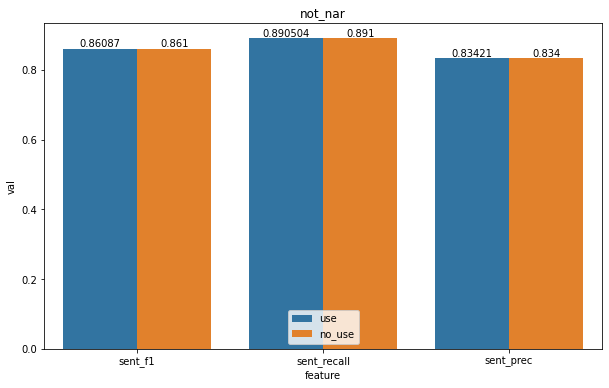

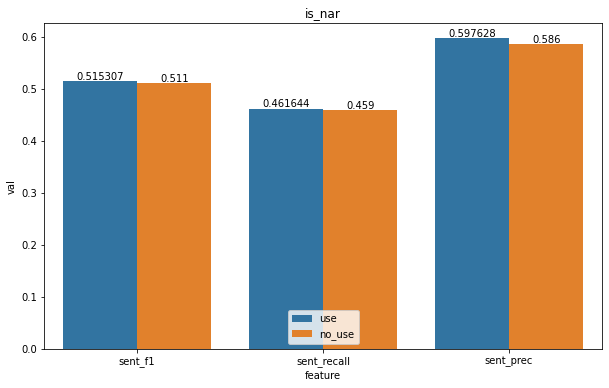

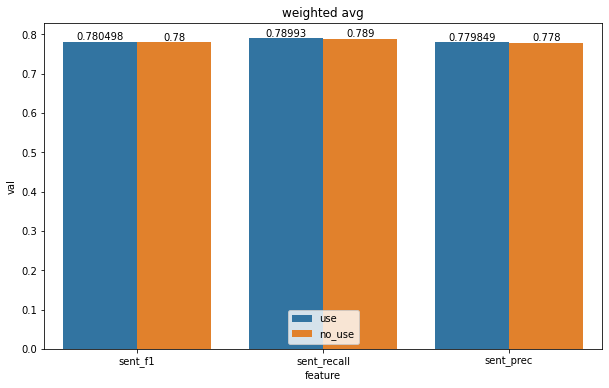

In [379]:
df=compare
ax={}
for l in df.label.unique():
    plt.figure(figsize=(10, 6))
    ax[l]= sns.barplot(x='feature',y='val',hue='lemma', data=df[df['label']==l],errwidth=0)
 

    for container in ax[l].containers:
        ax[l].bar_label(container)
    title = 'is_nar' if l == '1' else 'not_nar' if l == '0' else l
    ax[l].set_title(title)
    plt.legend(loc='lower center')
    plt.show()

In [368]:
unit_compare=pd.DataFrame()
for unit,val in my_tables.items():
    print('='*8+unit+'='*8)
    for k,v in val.print_df.items():
        print('{} {:.3f}'.format(k,v.loc['weighted avg','sent_f1']))
        unit_compare.loc[k,unit]=v.loc['weighted avg','sent_f1']
        if k == 'ens':
            print('fixed {} {:.3f}'.format(k,v.loc['weighted avg','fixed_f1']))
            unit_compare.loc['fixed_{}'.format(k),unit]=v.loc['weighted avg','fixed_f1']
unit_compare.rename({'group':'doc'},axis=1,inplace=True)
unit_compare.index.name='model'

========split========
bert 0.756
crf 0.780
ens 0.793
fixed ens 0.801
========group========
bert 0.760
crf 0.777
ens 0.791
fixed ens 0.799
========all========
bert 0.745
crf 0.778
ens 0.788
fixed ens 0.796


In [ ]:
unit_compare.

In [370]:
with pd.option_context('display.float_format', '{:0.3f}'.format):
    display(unit_compare)

,split,doc,all
model,,,
bert,0.756,0.760,0.745
crf,0.780,0.777,0.778
ens,0.793,0.791,0.788
fixed_ens,0.801,0.799,0.796


In [39]:
compare_fixes=pd.DataFrame()
for k,v in my_tables.items():
#     for col in v.print_df['ens'].columns:
#         if 'par' in col:
#             v.print_df['ens'].drop(col,inplace=True, axis=1)
#     if v.print_df['ens'].loc['weighted avg','fixed_f1']>=0.806:
# #     print(k,fix_options[k])
#     with pd.option_context('display.float_format', '{:0.3f}'.format):
#         display(v.print_df['ens'])
# # #         common_utils.save_db(v.print_df['ens'],dir_name,'fixed.f1.{}'.format(k))
    for c in v.print_df['ens'][['fixed_f1','fixed_recall','fixed_prec']]: #[['fixed_f1','fixed_recall','fixed_precision']]:
        for l in v.print_df['ens'].index:
            compare_fixes.loc[k,'{}_{}'.format(l,c)]=v.print_df['ens'].loc[l,c]
# compare_fixes.sort_values(by='weighted avg_fixed_f1')

In [40]:
with pd.option_context('display.float_format', '{:0.3f}'.format):
    display(compare_fixes)

,0_fixed_f1,1_fixed_f1,weighted avg_fixed_f1,0_fixed_recall,1_fixed_recall,weighted avg_fixed_recall,0_fixed_prec,1_fixed_prec,weighted avg_fixed_prec
sm.ssa,0.879,0.550,0.801,0.922,0.468,0.813,0.840,0.678,0.803


In [41]:
fixes=['weighted avg_fixed_f1','1_fixed_recall']
# fixes=['1_fixed_recall']
compare_fixes.sort_values(by=fixes,ascending=False).head()

,0_fixed_f1,1_fixed_f1,weighted avg_fixed_f1,0_fixed_recall,1_fixed_recall,weighted avg_fixed_recall,0_fixed_prec,1_fixed_prec,weighted avg_fixed_prec
sm.ssa,0.87861,0.54959,0.80136,0.92173,0.46817,0.81347,0.83990,0.67831,0.80328


In [42]:
compare_fixes[(compare_fixes['1_fixed_recall']>0.5)&(compare_fixes['weighted avg_fixed_f1']>=0.801)]

,0_fixed_f1,1_fixed_f1,weighted avg_fixed_f1,0_fixed_recall,1_fixed_recall,weighted avg_fixed_recall,0_fixed_prec,1_fixed_prec,weighted avg_fixed_prec


<AxesSubplot:>

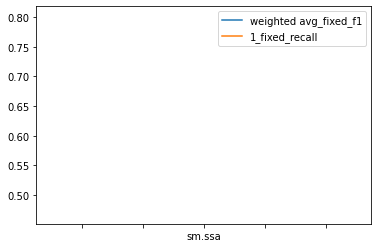

In [43]:
compare_fixes[['weighted avg_fixed_f1','1_fixed_recall']].head().plot()

In [44]:
best_fix=compare_fixes['1_fixed_recall'].idxmax()
# best_fix='tm.dm.sm.one.neigh'
best_fix='sm.ssa'

In [45]:
compare_fixes.loc[best_fix,:]

0_fixed_f1                  0.87861
1_fixed_f1                  0.54959
weighted avg_fixed_f1       0.80136
0_fixed_recall              0.92173
1_fixed_recall              0.46817
weighted avg_fixed_recall   0.81347
0_fixed_prec                0.83990
1_fixed_prec                0.67831
weighted avg_fixed_prec     0.80328
Name: sm.ssa, dtype: float64

In [46]:
my_tables[best_fix].my_fixer.fixed_df

,bert_group,bert_split,bert_predicted,bert_true,bert_proba_0,bert_proba_1,bert_sent_idx,bert_par,crf_group,crf_par,...,crf_proba_0,crf_proba_1,crf_sent_idx,ens_par_x,ens_predicted,ens_group,ens_split,ens_true,ens_par_y,ens_sent_idx
0,1,0,1,0,0.45525,0.54475,0,0,1,0,...,0.96872,0.03128,0,0,0,1,0,0,0,0
1,1,0,0,0,0.76593,0.23407,1,1,1,1,...,0.98367,0.01633,1,1,0,1,0,0,1,1
2,1,0,0,0,0.79398,0.20602,2,2,1,2,...,0.99680,0.00320,2,2,0,1,0,0,2,2
3,1,0,0,0,0.59757,0.40243,3,3,1,3,...,0.98790,0.01210,3,3,0,1,0,0,3,3
4,1,0,1,0,0.40709,0.59291,4,4,1,4,...,0.98713,0.01287,4,4,0,1,0,0,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38429,79,7,0,0,0.70014,0.29986,254,171,79,171,...,0.97277,0.02723,254,171,0,79,7,0,171,254
38430,79,7,0,0,0.84534,0.15466,255,172,79,172,...,0.89664,0.10336,255,172,0,79,7,0,172,255
38431,79,7,0,0,0.85442,0.14558,256,172,79,172,...,0.91198,0.08802,256,172,0,79,7,0,172,256
38432,79,7,0,0,0.84201,0.15799,257,172,79,172,...,0.92254,0.07746,257,172,0,79,7,0,172,257


In [47]:
common_utils.save_db(my_tables[best_fix].my_fixer.fixed_df,dir_name,'fixed_pred_{}.per.client'.format(best_fix))

Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/fixed_pred_sm.ssa.per.client.csv, 
index False
float_format %.5f


In [61]:
my_tables[best_fix].my_fixer.stat

{'bert': {'near': {'tot': 336, 'fp': 163, 'fn': 173},
  'mid': 1973,
  'mid_orig': 1031,
  'stand_alone': 672,
  'stand_alone_orig': 604,
  'total_fp': 5434,
  'total_fn': 4494},
 'crf': {'near': {'tot': 91, 'fp': 41, 'fn': 50},
  'mid': 31,
  'mid_orig': 31,
  'stand_alone': 2,
  'stand_alone_orig': 1,
  'total_fp': 3039,
  'total_fn': 5137},
 'ens': {'near': {'tot': 173, 'fp': 59, 'fn': 114},
  'mid': 524,
  'mid_orig': 356,
  'stand_alone': 225,
  'stand_alone_orig': 130,
  'total_fp': 2173,
  'total_fn': 5442}}

### Get stat on best fixes

In [272]:
fix_options[best_fix]

['single_miss', 'single_sa']

In [50]:
imp.reload(classes)
best_fix_stat=classes.MyScoreSummarizer(pred_df=all_pred_crf01,fix_list=fix_options[best_fix])
best_fix_stat.get_all_scores()

MyScoreSummarizer init called
MyPredFixer init called
WindowDiff init called
bert
near misses to be fixed
 {'tot': 336, 'fp': 163, 'fn': 173}
1973 middle misses to be fixed
672 stande alone to be fixed
crf
near misses to be fixed
 {'tot': 91, 'fp': 41, 'fn': 50}
31 middle misses to be fixed
2 stande alone to be fixed
ens
near misses to be fixed
 {'tot': 173, 'fp': 59, 'fn': 114}
524 middle misses to be fixed
225 stande alone to be fixed
MyReport init called
MyReport init called
MyReport init called


In [51]:
for a,b in best_fix_stat.my_fixer.stat.items():
    for c,d in b.items():
         print(a,'\t',c,'\t\t\t',d)

bert 	 near 			 {'tot': 336, 'fp': 163, 'fn': 173}
bert 	 mid 			 1973
bert 	 mid_orig 			 1031
bert 	 stand_alone 			 672
bert 	 stand_alone_orig 			 604
bert 	 total_fp 			 5434
bert 	 total_fn 			 4494
crf 	 near 			 {'tot': 91, 'fp': 41, 'fn': 50}
crf 	 mid 			 31
crf 	 mid_orig 			 31
crf 	 stand_alone 			 2
crf 	 stand_alone_orig 			 1
crf 	 total_fp 			 3039
crf 	 total_fn 			 5137
ens 	 near 			 {'tot': 173, 'fp': 59, 'fn': 114}
ens 	 mid 			 524
ens 	 mid_orig 			 356
ens 	 stand_alone 			 225
ens 	 stand_alone_orig 			 130
ens 	 total_fp 			 2173
ens 	 total_fn 			 5442


## get boundaries for fixd fm,tm,dm,sm


In [52]:
doc_to_use=4
t=best_fix

In [53]:
common_utils.save_db(my_tables[t].my_fixer.fixed_df,dir_name,'pred.fixed.per_client_{}'.format(t))

Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/pred.fixed.per_client_sm.ssa.csv, 
index False
float_format %.5f


In [54]:
wd = classes.WindowDiff()
start={}
end={}
est='ens'

my_pred=my_tables[t].my_fixer.fixed_df.copy()


est_gr='{}_group'.format(est)
est_pred='{}_predicted'.format(est)
start[t], end[t] = wd.get_boundaries_indices(my_pred.loc[my_pred[est_gr]==doc_to_use,est_pred].tolist())
bound_db={}
bound_db[t]=pd.DataFrame()
bound_db[t]['start']=start[t]
bound_db[t]['end']=end[t]
print(t,bound_db[t])
common_utils.save_db(bound_db[t],dir_name,'boundary_fixed_{}'.format(doc_to_use))

WindowDiff init called
sm.ssa     start  end
0       5    7
1      13   15
2      47   60
3      67   82
4      87  105
5     177  182
6     225  233
7     237  240
8     280  286
9     289  290
10    400  401
11    403  406
12    409  412
Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/boundary_fixed_4.csv, 
index False
float_format %.5f


In [55]:
my_pred=my_tables[t].my_fixer.orig_df.copy()
for est in ['crf','bert','ens']:
    est_gr='{}_group'.format(est)
    est_pred='{}_predicted'.format(est)
    start[est], end[est] = wd.get_boundaries_indices(my_pred.loc[my_pred[est_gr]==doc_to_use,est_pred].tolist())
    bound_db[est]=pd.DataFrame()
    bound_db[est]['start']=start[est]
    bound_db[est]['end']=end[est]
#     print(t,bound_db[est])
    common_utils.save_db(bound_db[est],dir_name,'boundary_{}_{}'.format(est,doc_to_use))

Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/boundary_crf_4.csv, 
index False
float_format %.5f
Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/boundary_bert_4.csv, 
index False
float_format %.5f
Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/boundary_ens_4.csv, 
index False
float_format %.5f


## Get baseline model boundary

In [386]:
baseline_pred=common_utils.load_db(dir_name,'Ridge.pred_all')

Opened /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/Ridge.pred_all.csv,  index False


In [394]:
baseline_pred['all_predicted']=baseline_pred['all_predicted'].astype(int)

In [399]:
base_pred=baseline_pred.loc[baseline_pred[est_gr]==doc_to_use,est_pred].tolist()
st,end=wd.get_boundaries_indices(base_pred)

In [400]:
len(st),len(end)

(33, 33)

In [404]:
est='all'
est_gr='{}_group'.format(est)
est_pred='{}_predicted'.format(est)
base_pred=baseline_pred.loc[baseline_pred[est_gr]==doc_to_use,est_pred].tolist()
st,end=wd.get_boundaries_indices(base_pred)
bound_db[est]=pd.DataFrame()
bound_db[est]['start']=st
bound_db[est]['end']=end
print(t,bound_db[est])
common_utils.save_db(bound_db[est],dir_name,'boundary_baseline_{}'.format(doc_to_use))


tm.dm.sm.ssa     start  end
0       5    7
1      18   22
2      39   40
3      48   49
4      52   55
5      56   57
6      58   59
7      69   74
8      75   76
9      87   88
10     89   90
11     91   92
12     93   94
13     99  103
14    104  105
15    108  109
16    142  143
17    151  152
18    159  160
19    161  162
20    177  178
21    180  181
22    197  198
23    199  200
24    207  208
25    216  217
26    224  225
27    280  282
28    283  284
29    286  287
30    288  290
31    404  405
32    409  410
Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/boundary_baseline_4.csv, 
index False
float_format %.5f


In [385]:
print(bound_db['ens'])

    start  end
0       5   15
1      18   20
2      45   60
3      65  105
4     176  179
5     180  184
6     195  210
7     225  227
8     231  234
9     237  238
10    239  240
11    241  242
12    279  286
13    390  391
14    392  393
15    394  398
16    400  405


In [311]:
est_gr,doc_to_use

('ens_group', 4)

In [312]:
my_tables[t].my_fixer.fixed_df.query('ens_group==4')

,bert_group,bert_split,bert_predicted,bert_true,bert_proba_0,bert_proba_1,bert_sent_idx,bert_par,crf_group,crf_par,...,crf_proba_0,crf_proba_1,crf_sent_idx,ens_par_x,ens_predicted,ens_group,ens_split,ens_true,ens_par_y,ens_sent_idx
0,4,0,0,0,0.71091,0.28909,0,0,4,0,...,0.94762,0.05238,0,0,0,4,0,0,0,0
1,4,0,0,0,0.76246,0.23754,1,1,4,1,...,0.95654,0.04346,1,1,0,4,0,0,1,1
2,4,0,0,0,0.81931,0.18069,2,2,4,2,...,0.96496,0.03504,2,2,0,4,0,0,2,2
3,4,0,0,0,0.52200,0.47800,3,3,4,3,...,0.83787,0.16213,3,3,0,4,0,0,3,3
4,4,0,0,0,0.68196,0.31804,4,3,4,3,...,0.69050,0.30950,4,3,0,4,0,0,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466,4,0,0,0,0.74785,0.25215,466,128,4,128,...,0.98562,0.01438,466,128,0,4,0,0,128,466
467,4,0,0,0,0.79953,0.20047,467,128,4,128,...,0.99452,0.00548,467,128,0,4,0,0,128,467
468,4,0,0,0,0.78473,0.21527,468,129,4,129,...,0.99627,0.00373,468,129,0,4,0,0,129,468
469,4,0,0,0,0.77627,0.22373,469,130,4,130,...,0.99655,0.00345,469,130,0,4,0,0,130,469


### Get unique mistakes

In [406]:
my_tables[t].my_fixer.pred_db

KeyError: 'bert'

In [422]:
types={'bert':0,'crf':0}
pos_label=1
mistakes={}
for t in types.keys():
    mistakes[t]={}
    l=types[t]
    mistakes[t]['total_index']=set(my_tables[best_fix].my_fixer.pred_df.query('{}_predicted!={}_true'.format(t,t)).index)
    mistakes[t]['false_neg_index']=set(my_tables[best_fix].my_fixer.pred_df.query('{}_predicted!={}_true and {}_predicted==@l'.format(t,t,t)).index)
    mistakes[t]['false_pos_index']=set(my_tables[best_fix].my_fixer.pred_df.query('{}_predicted!={}_true and {}_predicted==@pos_label'.format(t,t,t)).index)
    mistakes[t]['total_count']=len(mistakes[t]['total_index'])
    mistakes[t]['false_neg_count']=len(mistakes[t]['false_neg_index'])
    mistakes[t]['false_pos_count']=len(mistakes[t]['false_pos_index'])


In [423]:
mistakes['bert']['unique']=mistakes['bert']['total_index']-mistakes['crf']['total_index']
mistakes['crf']['unique']=mistakes['crf']['total_index']-mistakes['bert']['total_index']

mistakes['bert']['false_neg_unique']=mistakes['bert']['false_neg_index']-mistakes['crf']['false_neg_index']
mistakes['crf']['false_neg_unique']=mistakes['crf']['false_neg_index']-mistakes['bert']['false_neg_index']

mistakes['bert']['false_pos_unique']=mistakes['bert']['false_pos_index']-mistakes['crf']['false_pos_index']
mistakes['crf']['false_pos_unique']=mistakes['crf']['false_pos_index']-mistakes['bert']['false_pos_index']

for t in types:
    mistakes[t]['unique_count']=len(mistakes[t]['unique'])
    mistakes[t]['unique_ratio']=mistakes[t]['unique_count']/mistakes[t]['total_count']
    print("Unique mistakes of {} {}".format(t,mistakes[t]['unique_ratio']))

Unique mistakes of bert 0.5719021964359718
Unique mistakes of crf 0.4809697274211782


In [424]:
for k,v in mistakes.items():
    for i,j in v.items():
        if isinstance(j,set):
            print(k,i,len(j))
        else:
            print(k,i,j)

bert total_index 9652
bert false_neg_index 4518
bert false_pos_index 5134
bert total_count 9652
bert false_neg_count 4518
bert false_pos_count 5134
bert unique 5520
bert false_neg_unique 1732
bert false_pos_unique 3788
bert unique_count 5520
bert unique_ratio 0.5719021964359718
crf total_index 7961
crf false_neg_index 4783
crf false_pos_index 3178
crf total_count 7961
crf false_neg_count 4783
crf false_pos_count 3178
crf unique 3829
crf false_neg_unique 1997
crf false_pos_unique 1832
crf unique_count 3829
crf unique_ratio 0.4809697274211782


In [313]:
err_stat_db=pd.DataFrame()
for est_name,est_stat in my_tables[best_fix].my_fixer.stat.items():
    for stat_type,stat_val in est_stat.items():
        if stat_type=='near':
            for near_name,near_val in stat_val.items():
                err_stat_db.loc["{}_{}".format(stat_type,near_name),est_name]=near_val
        else:
            err_stat_db.loc["{}".format(stat_type),est_name]=stat_val
#             if stat_type in ['mid','stand_alone']:
#                 err_stat_db.loc["{}_rate".format(stat_type),est_name]=stat_val*100/estimator['total_fp']
#             if 'total' in err_type:
#                 err_stat_db.loc["{}_rate".format(stat_type),est_name]=stat_val*100/(estimator['total_fp']+estimator['total_fn'])
err_stat_db

,ens
near_tot,156.00000
near_fp,60.00000
near_fn,96.00000
tree_mid_miss,189.00000
double_mid_miss,324.00000
mid,474.00000


In [208]:
my_tables[best_fix].get_all_scores()

MyReport init called
MyReport init called
MyReport init called


In [62]:
for k,v in my_tables[best_fix].print_df.items():
#     if k!='ens':
#         print(k)
#     #     for col in v.columns:
#     #         if 'par' in col:
#     #             v.drop(col,inplace=True, axis=1)
#         with pd.option_context('display.float_format', '{:0.3f}'.format):
#             display(v)
#     else:
    print(k)
#     print('ens pure')
    with pd.option_context('display.float_format', '{:0.3f}'.format):

        display(v.drop(v.columns[v.columns.str.contains('fixed')], axis=1))
    if k == 'ens':
        with pd.option_context('display.float_format', '{:0.3f}'.format):

            print('ens fixed')
            display(v.drop(v.columns[v.columns.str.contains('sent')], axis=1))

bert


,sent_f1,sent_recall,sent_prec
0,0.823,0.810,0.837
1,0.519,0.544,0.497
weighted avg,0.745,0.742,0.750


crf


,sent_f1,sent_recall,sent_prec
0,0.862,0.894,0.833
1,0.536,0.479,0.608
weighted avg,0.778,0.787,0.775


ens


,sent_f1,sent_recall,sent_prec
0,0.874,0.924,0.829
1,0.537,0.448,0.670
weighted avg,0.788,0.802,0.788


ens fixed


,fixed_f1,fixed_recall,fixed_prec
0,0.877,0.921,0.837
1,0.561,0.478,0.677
weighted avg,0.796,0.808,0.796


In [64]:
for k,v in my_tables[best_fix].print_df.items():
    print('{} {:.3f}'.format(k,v.loc['weighted avg','sent_f1']))
    if k == 'ens':
        print('fixed {} {:.3f}'.format(k,v.loc['weighted avg','fixed_f1']))

bert 0.745
crf 0.778
ens 0.788
fixed ens 0.796


In [316]:
for k,v in my_tables[best_fix].print_df.items():
    print(k)
    if k != 'ens':
        for col in v.columns:
            if 'fixed' in col:
                v.drop(col,inplace=True, axis=1)
    with pd.option_context('display.float_format', '{:0.3f}'.format):
        display(v)

bert


,sent_f1,sent_recall,sent_prec
0,0.826,0.818,0.836
1,0.517,0.533,0.507
weighted avg,0.751,0.749,0.756


crf


,sent_f1,sent_recall,sent_prec
0,0.862,0.887,0.839
1,0.550,0.506,0.610
weighted avg,0.785,0.792,0.783


ens


,sent_f1,fixed_f1,sent_recall,fixed_recall,sent_prec,fixed_prec
0,0.871,0.871,0.907,0.894,0.840,0.850
1,0.565,0.589,0.501,0.547,0.657,0.647
weighted avg,0.795,0.801,0.804,0.807,0.796,0.802


In [24]:
doc_to_use=4

In [25]:
imp.reload(classes)
wd = classes.WindowDiff()
start={}
end={}
start['mer'], end['mer'] = wd.get_boundaries_indices(my_tables[best_fix].my_fixer.fixed_df.query('ens_group==@doc_to_use')['ens_predicted'].tolist())

WindowDiff init called


In [26]:
t='mer'
bound_db={}
bound_db[t]=pd.DataFrame()
bound_db[t]['start']=start[t]
bound_db[t]['end']=end[t]
common_utils.save_db(bound_db[t],dir_name,'boundary_{}_{}'.format(doc_to_use,t))

Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/boundary_4_mer.csv, 
index False
float_format %.5f


In [323]:
scores={}
scores_dict={}
scores[t], scores_dict[t], _, _ = model_utils.get_report_by_unit(my_tables[best_fix].my_fixer.fixed_df.query('ens_group==@doc_to_use'),'ens',"group")

KeyError: 'ens_par'

### Load true nar indices

In [216]:
dir_name

'duplicate'

In [217]:
sent_db =  common_utils.concat_dbs(dir_name,"sent_db",['is_nar','nar_idx'],'sent_idx')

In [218]:
sent_db

,doc_idx,sent_idx,is_nar,nar_idx
0,1,0,0.00000,0.00000
1,1,1,0.00000,0.00000
2,1,2,0.00000,0.00000
3,1,3,0.00000,0.00000
4,1,4,0.00000,0.00000
...,...,...,...,...
38429,80,525,0.00000,0.00000
38430,80,526,0.00000,0.00000
38431,80,527,0.00000,0.00000
38432,80,528,0.00000,0.00000


## Merge pred db with sent_db

In [219]:
best_fix

'sm.ssa'

In [250]:
imp.reload(classes)
imp.reload(model_utils)
my_tables[best_fix].get_all_scores('group')

MyReport init called


/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

MyReport init called


/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

MyReport init called


In [268]:
for k,v in my_tables[best_fix].print_df.items():
    print(k)
    display(v)

bert


,sent_f1,fixed_f1,sent_recall,fixed_recall,sent_prec,fixed_prec
0,0.82552,0.83215,0.82190,0.80970,0.83641,0.86415
1,0.48769,0.54617,0.54046,0.63757,0.48468,0.51564
weighted avg,0.76409,0.78355,0.75811,0.77536,0.78104,0.80621


crf


,sent_f1,fixed_f1,sent_recall,fixed_recall,sent_prec,fixed_prec
0,0.85580,0.85662,0.88664,0.88659,0.83620,0.83782
1,0.48134,0.48633,0.47286,0.47827,0.59318,0.59219
weighted avg,0.78518,0.78706,0.79437,0.79586,0.80422,0.80538


ens


,sent_f1,fixed_f1,sent_recall,fixed_recall,sent_prec,fixed_prec
0,0.86782,0.87017,0.90850,0.90610,0.83925,0.84566
1,0.50773,0.52412,0.47764,0.50050,0.64293,0.63561
weighted avg,0.79879,0.80476,0.80886,0.81357,0.81852,0.82249


In [253]:
ens_pred=my_tables[best_fix].my_fixer.fixed_df.copy()

In [254]:
ens_pred

,bert_group,bert_split,bert_predicted,bert_true,bert_proba_0,bert_proba_1,bert_sent_idx,bert_par,crf_group,crf_par,...,crf_proba_0,crf_proba_1,crf_sent_idx,ens_par_x,ens_predicted,ens_group,ens_split,ens_true,ens_par_y,ens_sent_idx
0,4,0,0,0,0.71091,0.28909,0,0,4,0,...,0.94762,0.05238,0,0,0,4,0,0,0,0
1,4,0,0,0,0.76246,0.23754,1,1,4,1,...,0.95654,0.04346,1,1,0,4,0,0,1,1
2,4,0,0,0,0.81931,0.18069,2,2,4,2,...,0.96496,0.03504,2,2,0,4,0,0,2,2
3,4,0,0,0,0.52200,0.47800,3,3,4,3,...,0.83787,0.16213,3,3,0,4,0,0,3,3
4,4,0,0,0,0.68196,0.31804,4,3,4,3,...,0.69050,0.30950,4,3,0,4,0,0,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38429,79,9,0,0,0.70257,0.29743,254,171,79,171,...,0.97538,0.02462,254,171,0,79,9,0,171,254
38430,79,9,0,0,0.82715,0.17285,255,172,79,172,...,0.96152,0.03848,255,172,0,79,9,0,172,255
38431,79,9,0,0,0.84322,0.15678,256,172,79,172,...,0.97381,0.02619,256,172,0,79,9,0,172,256
38432,79,9,0,0,0.83315,0.16685,257,172,79,172,...,0.97444,0.02556,257,172,0,79,9,0,172,257


In [255]:
my_tables[best_fix].print_df['ens']

,sent_f1,fixed_f1,sent_recall,fixed_recall,sent_prec,fixed_prec
0,0.86782,0.87017,0.90850,0.90610,0.83925,0.84566
1,0.50773,0.52412,0.47764,0.50050,0.64293,0.63561
weighted avg,0.79879,0.80476,0.80886,0.81357,0.81852,0.82249


group 4
              precision    recall  f1-score   support

           0       0.78      0.92      0.84       298
           1       0.80      0.56      0.66       173

    accuracy                           0.79       471
   macro avg       0.79      0.74      0.75       471
weighted avg       0.79      0.79      0.78       471

group 14
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       586
           1       0.50      0.52      0.51        82

    accuracy                           0.88       668
   macro avg       0.72      0.73      0.72       668
weighted avg       0.88      0.88      0.88       668

group 15
              precision    recall  f1-score   support

           0       0.99      0.92      0.95       674
           1       0.21      0.74      0.32        19

    accuracy                           0.91       693
   macro avg       0.60      0.83      0.64       693
weighted avg       0.97      0.91      0.94     

/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

group 58
              precision    recall  f1-score   support

           0       0.85      0.90      0.87       494
           1       0.37      0.27      0.31       108

    accuracy                           0.79       602
   macro avg       0.61      0.58      0.59       602
weighted avg       0.76      0.79      0.77       602

group 1
              precision    recall  f1-score   support

           0       0.71      0.77      0.74       357
           1       0.63      0.55      0.59       256

    accuracy                           0.68       613
   macro avg       0.67      0.66      0.66       613
weighted avg       0.67      0.68      0.67       613

group 19
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       324
           1       0.44      0.52      0.48        29

    accuracy                           0.91       353
   macro avg       0.70      0.73      0.71       353
weighted avg       0.91      0.91      0.91     

group 25
              precision    recall  f1-score   support

           0       0.94      0.83      0.89       412
           1       0.35      0.63      0.45        57

    accuracy                           0.81       469
   macro avg       0.64      0.73      0.67       469
weighted avg       0.87      0.81      0.83       469

group 30
              precision    recall  f1-score   support

           0       0.86      1.00      0.93       552
           1       1.00      0.32      0.49       130

    accuracy                           0.87       682
   macro avg       0.93      0.66      0.71       682
weighted avg       0.89      0.87      0.84       682

group 38
              precision    recall  f1-score   support

           0       0.86      1.00      0.93       137
           1       1.00      0.37      0.54        35

    accuracy                           0.87       172
   macro avg       0.93      0.69      0.73       172
weighted avg       0.89      0.87      0.85    

group 60
              precision    recall  f1-score   support

           0       0.82      0.93      0.87       296
           1       0.82      0.62      0.71       161

    accuracy                           0.82       457
   macro avg       0.82      0.77      0.79       457
weighted avg       0.82      0.82      0.81       457

group 64
              precision    recall  f1-score   support

           0       0.92      0.95      0.93       631
           1       0.70      0.59      0.64       130

    accuracy                           0.89       761
   macro avg       0.81      0.77      0.79       761
weighted avg       0.88      0.89      0.88       761

group 78
              precision    recall  f1-score   support

           0       0.86      0.91      0.88       146
           1       0.58      0.45      0.51        40

    accuracy                           0.81       186
   macro avg       0.72      0.68      0.70       186
weighted avg       0.80      0.81      0.80    

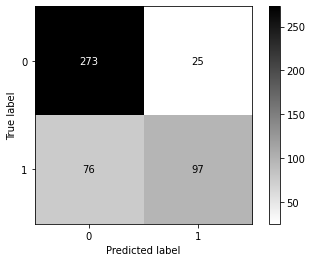

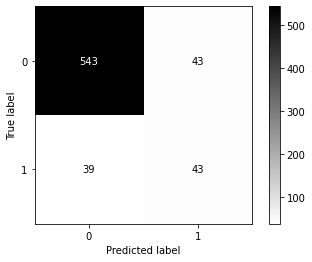

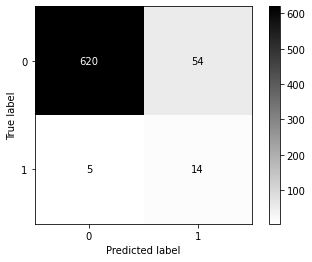

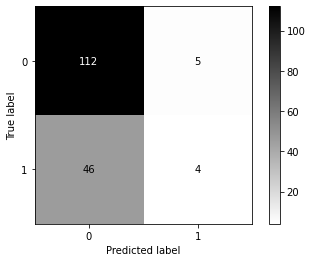

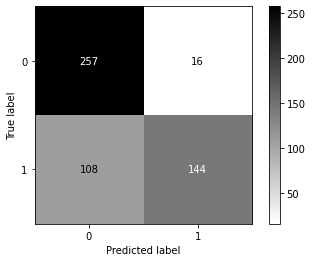

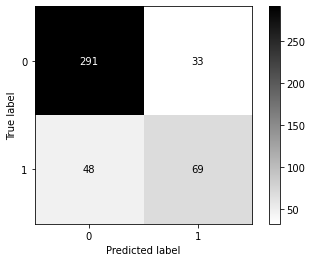

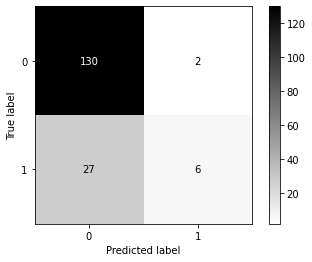

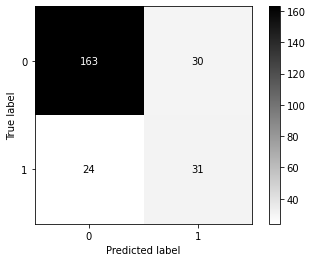

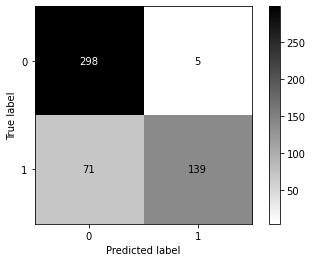

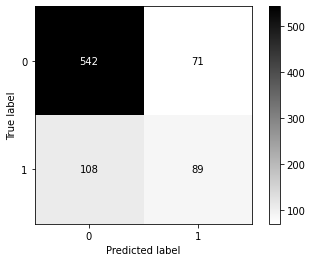

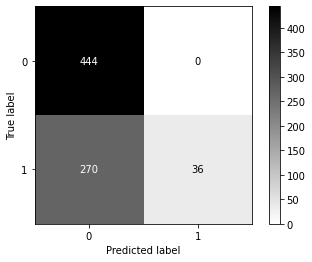

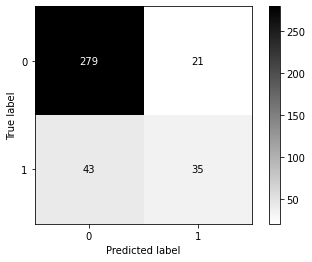

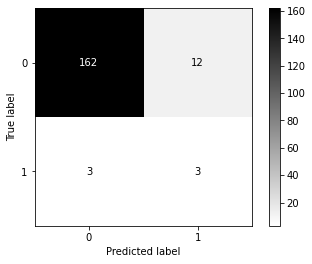

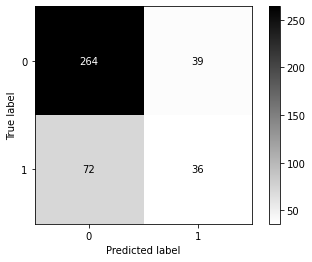

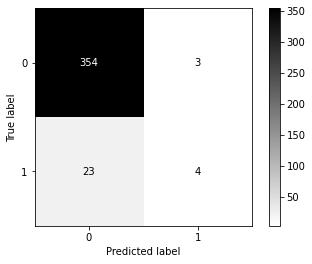

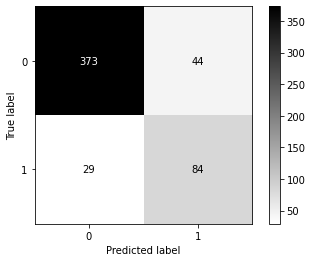

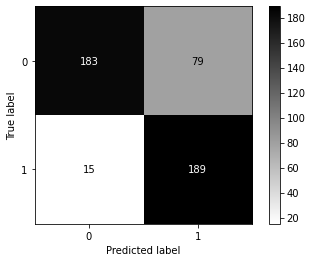

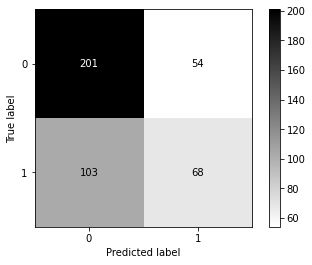

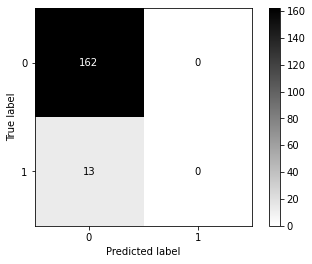

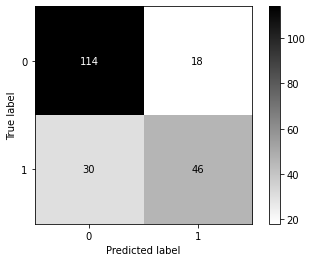

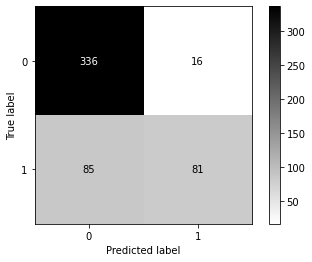

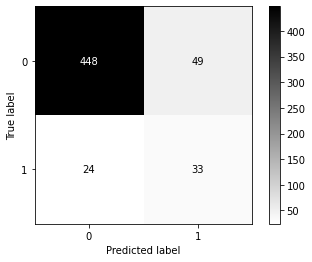

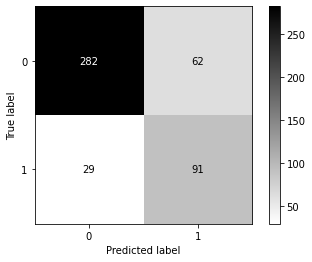

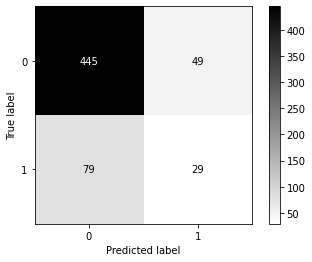

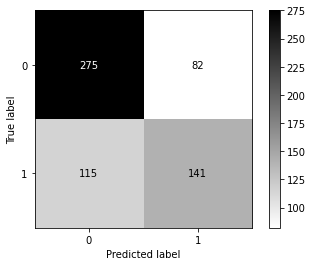

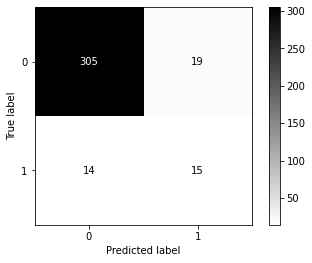

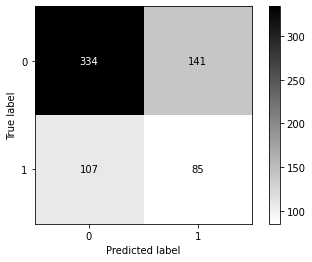

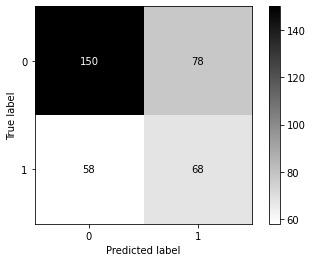

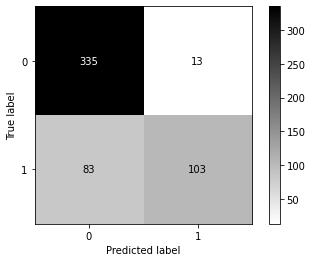

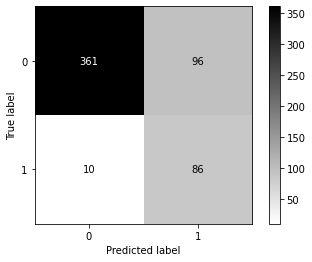

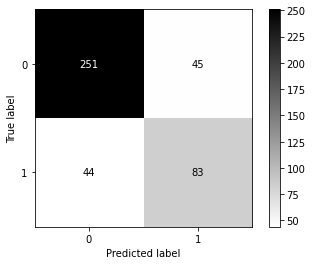

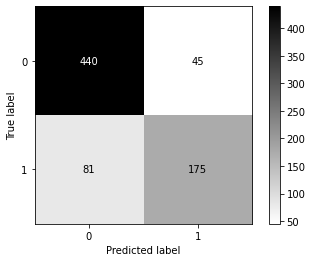

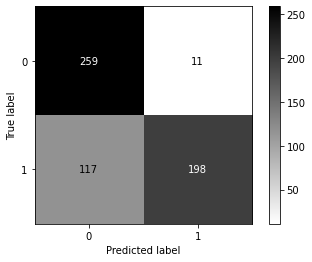

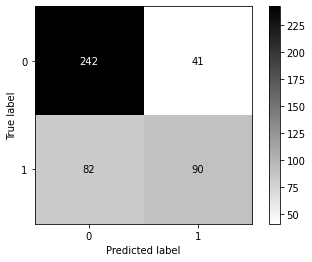

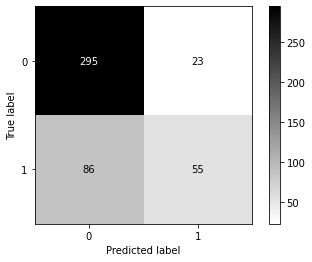

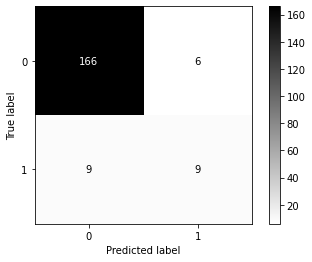

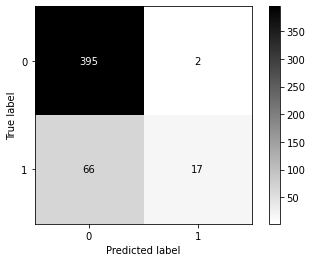

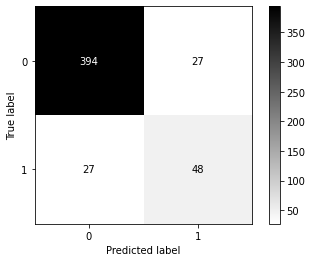

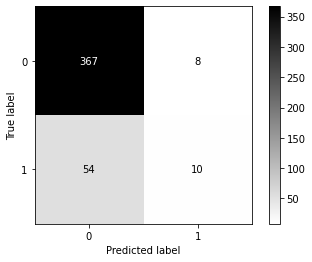

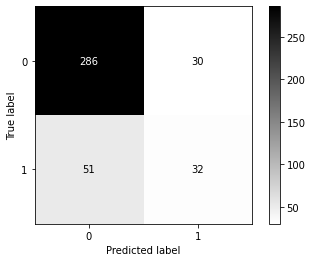

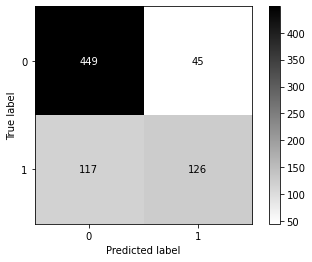

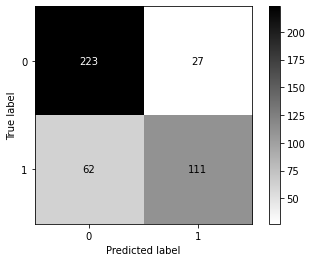

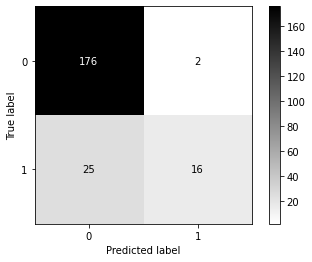

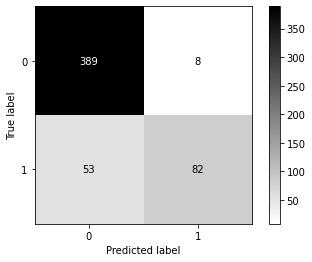

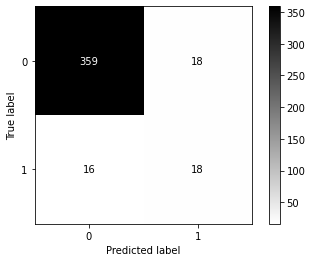

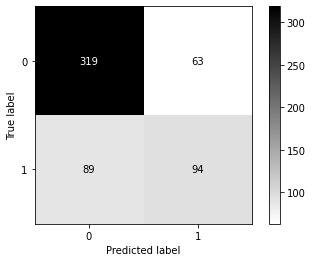

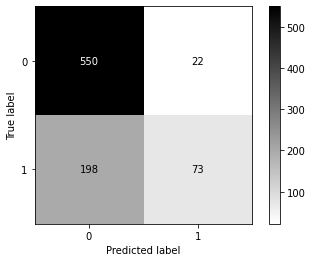

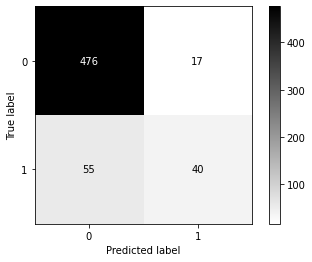

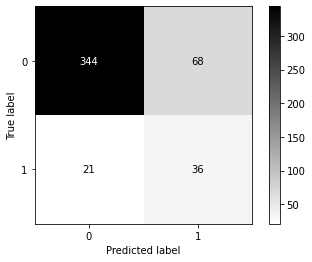

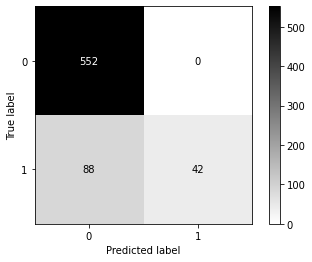

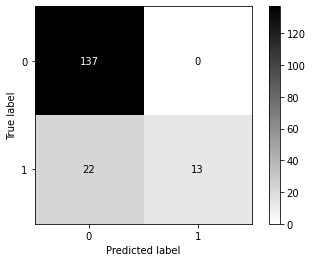

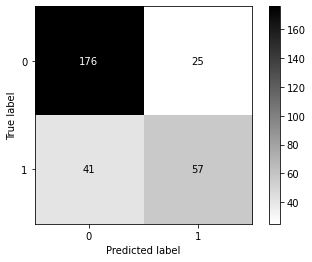

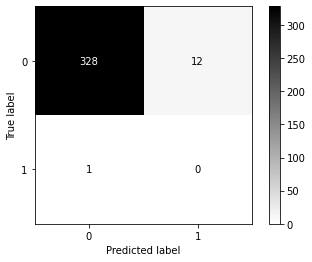

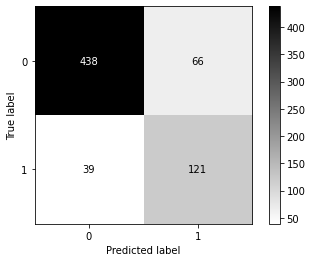

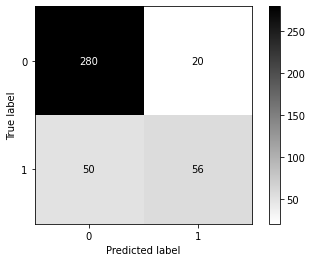

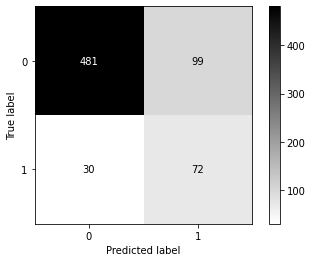

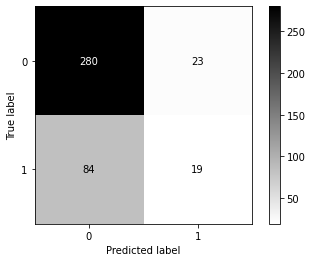

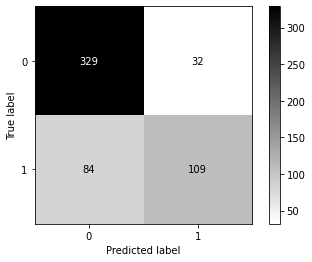

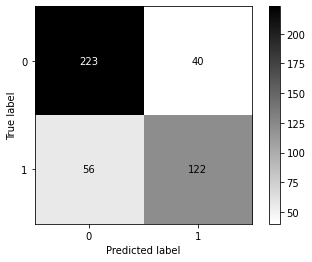

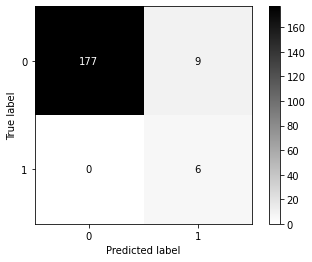

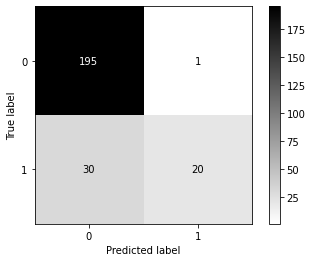

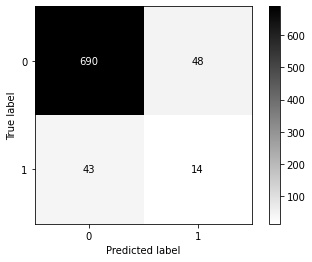

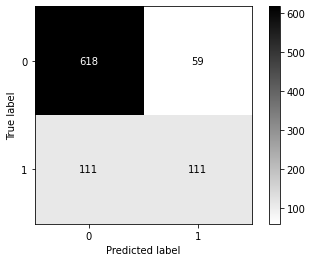

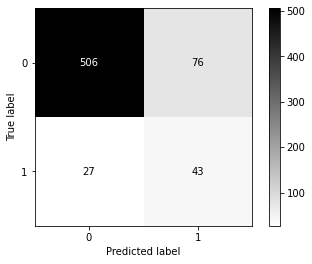

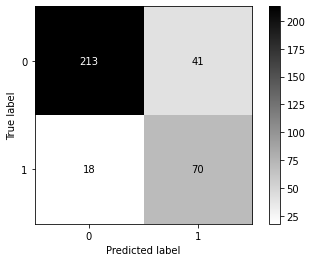

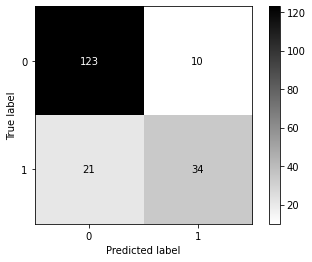

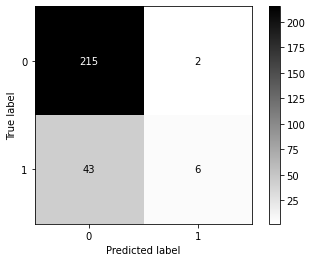

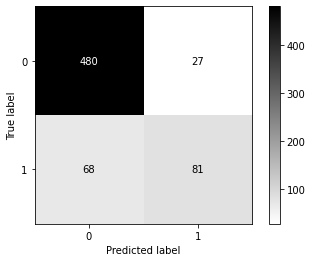

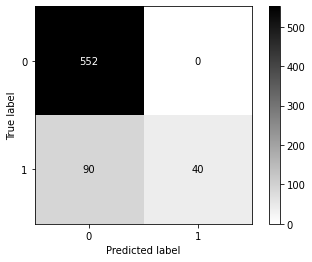

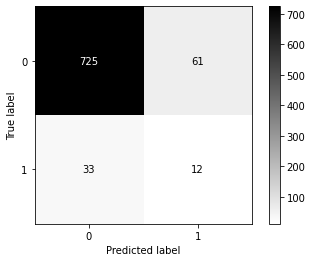

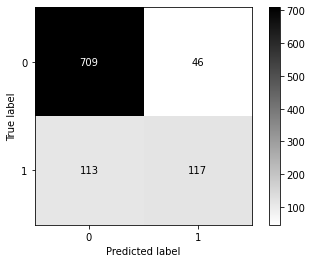

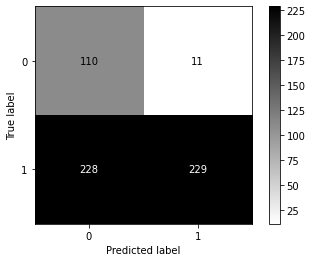

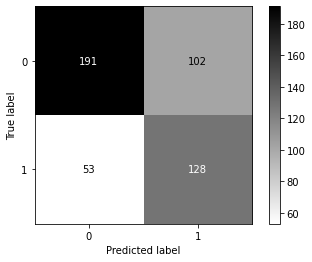

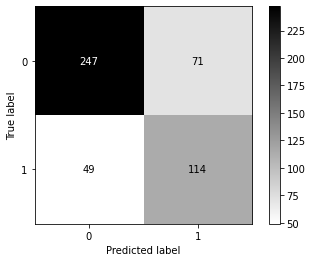

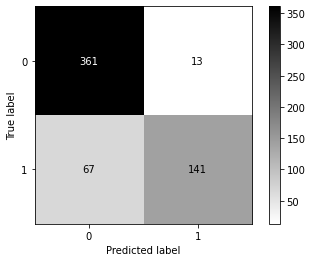

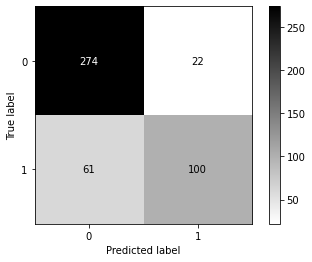

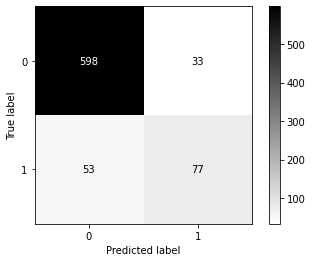

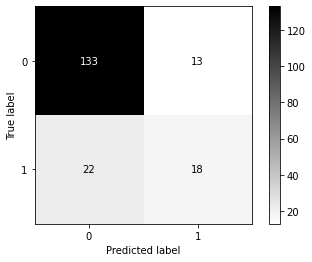

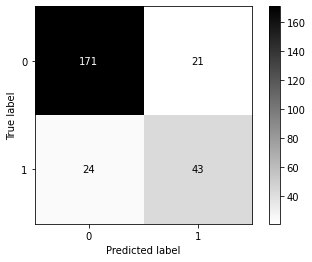

In [260]:
sc,dic,_,_=model_utils.get_report_by_unit(ens_pred,'ens','group',n_t=2, print_rep=True, segeval =False, use_par=False)

In [261]:
f1_rec=[]
for k,v in dic.items():
    f1_rec.append(v['1']['recall'])

In [262]:
np.mean(f1_rec)

0.5005030151425921

In [263]:
sent_db

,doc_idx,sent_idx,is_nar,nar_idx
0,1,0,0.00000,0.00000
1,1,1,0.00000,0.00000
2,1,2,0.00000,0.00000
3,1,3,0.00000,0.00000
4,1,4,0.00000,0.00000
...,...,...,...,...
38429,80,525,0.00000,0.00000
38430,80,526,0.00000,0.00000
38431,80,527,0.00000,0.00000
38432,80,528,0.00000,0.00000


In [264]:
sent_db[sent_db['is_nar']==1]['nar_idx'].unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18.])

In [265]:
nar_idx_db=sent_db.merge(ens_pred[['ens_true','ens_predicted','ens_group','ens_sent_idx']],left_on=['doc_idx','sent_idx'],right_on=['ens_group','ens_sent_idx'],validate='one_to_one')

In [266]:
nar_idx_db[nar_idx_db['ens_true']==1].shape[0]

9856

In [267]:
nar_idx_db[nar_idx_db['ens_predicted']==1].shape[0]

7847

In [239]:
rec=len(set(nar_idx_db[nar_idx_db['ens_true']==1].index)&set(nar_idx_db[nar_idx_db['ens_predicted']==1].index))/len(nar_idx_db[nar_idx_db['ens_true']==1])
rec

0.5272930194805194

In [152]:
common_utils.save_db(nar_idx_db,dir_name,'nar_idx_db')

Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/nar_idx_db.csv, 
index False
float_format %.5f


In [141]:
true_nar_len=nar_idx_db[nar_idx_db['is_nar']==1].groupby(['doc_idx','nar_idx']).size().reset_index(name='nar_len')
true_nar_len

,doc_idx,nar_idx,nar_len
0,1,1.00000,43
1,1,2.00000,24
2,1,3.00000,19
3,1,4.00000,11
4,1,5.00000,22
...,...,...,...
643,79,13.00000,1
644,80,1.00000,11
645,80,2.00000,40
646,80,3.00000,45


In [153]:
common_utils.save_db(true_nar_len,dir_name,'true_nar_len')

Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/true_nar_len.csv, 
index False
float_format %.5f


In [193]:
# df.name2.eq(df.name1)
pred_hit=nar_idx_db[(nar_idx_db['ens_true'].eq(nar_idx_db['ens_predicted']))&(nar_idx_db['ens_true']==1)].groupby(['doc_idx','nar_idx']).size().reset_index(name='pred_hit')
pred_hit

,doc_idx,nar_idx,pred_hit
0,1,1.00000,18
1,1,2.00000,24
2,1,3.00000,11
3,1,5.00000,13
4,1,6.00000,51
...,...,...,...
433,79,10.00000,2
434,79,11.00000,3
435,80,1.00000,11
436,80,2.00000,30


In [154]:
common_utils.save_db(pred_hit,dir_name,'pred_hit_len')

Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/pred_hit_len.csv, 
index False
float_format %.5f


In [194]:
compare=true_nar_len.merge(pred_hit,left_on=['doc_idx','nar_idx'],right_on=['doc_idx','nar_idx'],how='outer',validate='one_to_one')

In [195]:
compare['hit_ratio']=compare['pred_hit']/compare['nar_len']

In [196]:
compare

,doc_idx,nar_idx,nar_len,pred_hit,hit_ratio
0,1,1.00000,43,18.00000,0.41860
1,1,2.00000,24,24.00000,1.00000
2,1,3.00000,19,11.00000,0.57895
3,1,4.00000,11,NaN,NaN
4,1,5.00000,22,13.00000,0.59091
...,...,...,...,...,...
643,79,13.00000,1,NaN,NaN
644,80,1.00000,11,11.00000,1.00000
645,80,2.00000,40,30.00000,0.75000
646,80,3.00000,45,43.00000,0.95556


In [197]:
compare.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 648 entries, 0 to 647
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   doc_idx    648 non-null    int64  
 1   nar_idx    648 non-null    float64
 2   nar_len    648 non-null    int64  
 3   pred_hit   438 non-null    float64
 4   hit_ratio  438 non-null    float64
dtypes: float64(3), int64(2)
memory usage: 30.4 KB


In [198]:
compare['pred_hit'].count()*100/compare['nar_len'].count()

67.5925925925926

In [199]:
threshold=0.3

In [200]:
compare[compare['hit_ratio']>=threshold].shape[0]

393

In [203]:
compare[compare['hit_ratio']>=0.5].shape[0]*100/compare['nar_len'].count()

51.388888888888886

In [201]:
compare[compare['hit_ratio']>=threshold].shape[0]*100/compare['nar_len'].count()

60.648148148148145

<AxesSubplot:ylabel='Frequency'>

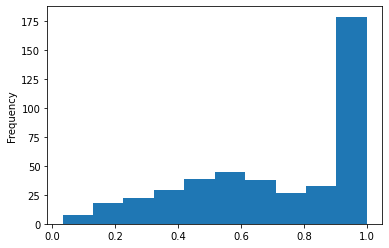

In [202]:
compare['hit_ratio'].plot(kind='hist',bins=10)

In [177]:
np.nanpercentile(compare['hit_ratio'],50)

0.7717121588089331

In [179]:
np.nanquantile(compare['hit_ratio'],0.5)

0.7717121588089331

In [173]:
compare[compare['hit_ratio']>=threshold].shape[0]

333

In [160]:
common_utils.save_db(compare,dir_name,'nar_hit_ratio')

Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/nar_hit_ratio.csv, 
index False
float_format %.5f


In [159]:
threshold=0.5
compare[compare['hit_ratio']>threshold].shape[0]

323

### Find true narratives

In [35]:
fixed_df=my_tables[best_fix].my_fixer.fixed_df.copy()

In [43]:
consecutives=fixed_df.groupby('ens_group')['ens_true'].diff().ne(0).cumsum()
consecutives

0           1
1           1
2           1
3           1
4           1
         ... 
38429    1353
38430    1353
38431    1353
38432    1353
38433    1353
Name: ens_true, Length: 38434, dtype: int64

In [64]:
fixed_df['abs_idx']=fixed_df.index
fixed_df

,bert_group,bert_split,bert_predicted,bert_true,bert_proba_0,bert_proba_1,bert_sent_idx,bert_par,crf_group,crf_par,...,crf_sent_idx,ens_par_x,ens_predicted,ens_group,ens_split,ens_true,ens_par_y,ens_sent_idx,segments,abs_idx
idx,,,,,,,,,,,,,,,,,,,,,
0,4,0,0,0,0.71091,0.28909,0,0,4,0,...,0,0,0,4,0,0,0,0,1,0
1,4,0,0,0,0.76246,0.23754,1,1,4,1,...,1,1,0,4,0,0,1,1,1,1
2,4,0,0,0,0.81931,0.18069,2,2,4,2,...,2,2,0,4,0,0,2,2,1,2
3,4,0,0,0,0.52200,0.47800,3,3,4,3,...,3,3,0,4,0,0,3,3,1,3
4,4,0,0,0,0.68196,0.31804,4,3,4,3,...,4,3,0,4,0,0,3,4,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38429,79,9,0,0,0.70257,0.29743,254,171,79,171,...,254,171,0,79,9,0,171,254,1353,38429
38430,79,9,0,0,0.82715,0.17285,255,172,79,172,...,255,172,0,79,9,0,172,255,1353,38430
38431,79,9,0,0,0.84322,0.15678,256,172,79,172,...,256,172,0,79,9,0,172,256,1353,38431


In [67]:
fixed_df[fixed_df['ens_true']==1]

,bert_group,bert_split,bert_predicted,bert_true,bert_proba_0,bert_proba_1,bert_sent_idx,bert_par,crf_group,crf_par,...,crf_sent_idx,ens_par_x,ens_predicted,ens_group,ens_split,ens_true,ens_par_y,ens_sent_idx,segments,abs_idx
idx,,,,,,,,,,,,,,,,,,,,,
5,4,0,1,1,0.25015,0.74985,5,3,4,3,...,5,3,1,4,0,1,3,5,2,5
6,4,0,1,1,0.13159,0.86841,6,3,4,3,...,6,3,1,4,0,1,3,6,2,6
7,4,0,0,1,0.80343,0.19657,7,3,4,3,...,7,3,1,4,0,1,3,7,2,7
8,4,0,0,1,0.75514,0.24486,8,3,4,3,...,8,3,1,4,0,1,3,8,2,8
9,4,0,0,1,0.74079,0.25921,9,3,4,3,...,9,3,1,4,0,1,3,9,2,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38355,79,9,1,1,0.18380,0.81620,180,120,79,120,...,180,120,1,79,9,1,120,180,1348,38355
38356,79,9,1,1,0.09210,0.90790,181,121,79,121,...,181,121,1,79,9,1,121,181,1348,38356
38357,79,9,1,1,0.17029,0.82971,182,121,79,121,...,182,121,1,79,9,1,121,182,1348,38357


In [76]:
agg_true=fixed_df[['abs_idx','ens_true']].groupby(consecutives).agg(list).copy()

In [79]:
imp.reload(common_utils)
agg_true['is_nar']=agg_true['ens_true'].apply(common_utils.get_single_unique)

In [86]:
agg_true['is_nar'].diff().ne(0).cumsum()

ens_true
1          1
2          2
3          3
4          4
5          5
        ... 
1349    1275
1350    1276
1351    1277
1352    1278
1353    1279
Name: is_nar, Length: 1353, dtype: int64

In [84]:
common_utils.save_db(agg_true[agg_true['is_nar']==1],dir_name,'true_nar_aggr')

Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/true_nar_aggr.csv, 
index False
float_format %.5f


In [329]:
scores

{'mer': [0.7802652911744257]}

In [312]:
for k,v in my_tables.latex_str.items():
    print(k)
    display(v)

bert


'&sent_f1&fixed_f1&par_f1&sent_recall&fixed_recall&par_recall&sent_prec&fixed_prec&par_prec\\0&0.820&0.864&0.814&0.809&0.856&0.756&0.835&0.875&0.887\\1&0.516&0.625&0.467&0.546&0.652&0.613&0.503&0.617&0.387\\weighted avg&0.745&0.805&0.748&0.740&0.802&0.726&0.756&0.814&0.792\\'

crf


'&sent_f1&fixed_f1&par_f1&sent_recall&fixed_recall&par_recall&sent_prec&fixed_prec&par_prec\\0&0.859&0.860&0.886&0.885&0.885&0.904&0.836&0.837&0.871\\1&0.545&0.548&0.494&0.500&0.503&0.459&0.606&0.609&0.542\\weighted avg&0.781&0.782&0.810&0.789&0.790&0.816&0.780&0.781&0.808\\'

ens


'&sent_f1&fixed_f1&par_f1&sent_recall&fixed_recall&par_recall&sent_prec&fixed_prec&par_prec\\0&0.874&0.882&0.899&0.921&0.928&0.928&0.832&0.842&0.873\\1&0.550&0.583&0.518&0.470&0.502&0.458&0.677&0.710&0.607\\weighted avg&0.793&0.807&0.825&0.805&0.818&0.834&0.797&0.812&0.824\\'

In [359]:
imp.reload(classes)

my_tables_sinle_on_pred=classes.MyScoreSummarizer(all_pred_crf01,False)
my_tables_sinle_on_pred.get_all_scores()

MyScoreSummarizer init called
MyPredFixer init called
WindowDiff init called
bert
near misses to be fixed
 {'tot': 321, 'fp': 151, 'fn': 170}


TypeError: 'bool' object is not iterable

In [367]:
scores_dict

{0: {'0': {'precision': 0.8285335981463091,
   'recall': 0.9638043896804005,
   'f1-score': 0.891064435742257,
   'support': 2597},
  '1': {'precision': 0.7366946778711485,
   'recall': 0.33674775928297057,
   'f1-score': 0.46221441124780316,
   'support': 781},
  'accuracy': 0.8188277087033747,
  'macro avg': {'precision': 0.7826141380087288,
   'recall': 0.6502760744816856,
   'f1-score': 0.6766394234950301,
   'support': 3378},
  'weighted avg': {'precision': 0.8073002657795535,
   'recall': 0.8188277087033747,
   'f1-score': 0.7919134975746523,
   'support': 3378}},
 1: {'0': {'precision': 0.7917374080362196,
   'recall': 0.9611817244933013,
   'f1-score': 0.8682699767261443,
   'support': 2911},
  '1': {'precision': 0.7322274881516587,
   'recall': 0.29569377990430623,
   'f1-score': 0.42126789366053163,
   'support': 1045},
  'accuracy': 0.7853892821031345,
  'macro avg': {'precision': 0.7619824480939392,
   'recall': 0.6284377521988038,
   'f1-score': 0.6447689351933379,
   'sup

In [306]:
for k,v in my_tables_sinle_on_pred.print_df.items():
    print(k)
    for col in v.columns:
        if 'par' in col:
            v.drop(col,inplace=True, axis=1)
    display(v)

bert


,sent_f1,fixed_f1,sent_recall,fixed_recall,sent_prec,fixed_prec
0,0.82023,0.83640,0.80913,0.82096,0.83516,0.85681
1,0.51576,0.56771,0.54572,0.60928,0.50346,0.54924
weighted avg,0.74459,0.76990,0.74004,0.76504,0.75607,0.78380


crf


,sent_f1,fixed_f1,sent_recall,fixed_recall,sent_prec,fixed_prec
0,0.85913,0.85933,0.88497,0.88480,0.83550,0.83605
1,0.54454,0.54609,0.49971,0.50186,0.60624,0.60690
weighted avg,0.78118,0.78172,0.78850,0.78891,0.77993,0.78050


ens


,sent_f1,fixed_f1,sent_recall,fixed_recall,sent_prec,fixed_prec
0,0.87389,0.87587,0.92133,0.92166,0.83226,0.83565
1,0.54962,0.56061,0.46967,0.48259,0.67712,0.68512
weighted avg,0.79277,0.79693,0.80533,0.80881,0.79736,0.80172


In [307]:
imp.reload(classes)

my_tables_double_on_pred=classes.MyScoreSummarizer(all_pred_crf01,True)
my_tables_double_on_pred.get_all_scores()

MyScoreSummarizer init called
MyPredFixer init called
WindowDiff init called
bert
near misses to be fixed
 {'tot': 346, 'fp': 162, 'fn': 184}
1890 middle misses to be fixed
1633 stande alone to be fixed
501 double stande alone to be fixed
274 double middle misses to be fixed
crf
near misses to be fixed
 {'tot': 100, 'fp': 48, 'fn': 52}
0 middle misses to be fixed
0 stande alone to be fixed
5 double stande alone to be fixed
6 double middle misses to be fixed
ens
near misses to be fixed
 {'tot': 156, 'fp': 57, 'fn': 99}
399 middle misses to be fixed
350 stande alone to be fixed
134 double stande alone to be fixed
69 double middle misses to be fixed
MyReport init called
MyReport init called
MyReport init called


In [308]:
for k,v in my_tables_double_on_pred.print_df.items():
    print(k)
    for col in v.columns:
        if 'par' in col:
            v.drop(col,inplace=True, axis=1)
    display(v)

bert


,sent_f1,fixed_f1,sent_recall,fixed_recall,sent_prec,fixed_prec
0,0.82023,0.83931,0.80913,0.82712,0.83516,0.85616
1,0.51576,0.56875,0.54572,0.60400,0.50346,0.55610
weighted avg,0.74459,0.77229,0.74004,0.76829,0.75607,0.78508


crf


,sent_f1,fixed_f1,sent_recall,fixed_recall,sent_prec,fixed_prec
0,0.85913,0.85933,0.88497,0.88479,0.83550,0.83606
1,0.54454,0.54622,0.49971,0.50200,0.60624,0.60706
weighted avg,0.78118,0.78174,0.78850,0.78893,0.77993,0.78054


ens


,sent_f1,fixed_f1,sent_recall,fixed_recall,sent_prec,fixed_prec
0,0.87389,0.87609,0.92133,0.92298,0.83226,0.83501
1,0.54962,0.55927,0.46967,0.47978,0.67712,0.68745
weighted avg,0.79277,0.79668,0.80533,0.80891,0.79736,0.80190


### Try to train ensemble on merged predictions

In [333]:
cv_splits_loaded=common_utils.load_json(dir_name,cv_split_name)
cv_splits_loaded

Opened /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/cv_splits_10.json


{'0': {'test': [4, 14, 15, 18, 29, 32, 36, 70],
  'train': [1,
   2,
   3,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   16,
   17,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   30,
   31,
   33,
   34,
   35,
   37,
   38,
   39,
   40,
   41,
   42,
   43,
   44,
   45,
   46,
   47,
   48,
   49,
   50,
   51,
   52,
   53,
   54,
   55,
   56,
   57,
   58,
   59,
   60,
   61,
   62,
   63,
   64,
   65,
   66,
   67,
   68,
   69,
   71,
   72,
   73,
   74,
   75,
   76,
   77,
   78,
   79,
   80]},
 '1': {'test': [5, 6, 13, 34, 37, 62, 73, 80],
  'train': [1,
   2,
   3,
   4,
   7,
   8,
   9,
   10,
   11,
   12,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   29,
   30,
   31,
   32,
   33,
   35,
   36,
   38,
   39,
   40,
   41,
   42,
   43,
   44,
   45,
   46,
   47,
   48,
   49,
   50,
   51,
   52,
   53,
   54,
   55,
   56,
   57,
   58,
   59,
   60,
   61,
   6

In [336]:
fixed_pred=my_tables_sinle_on_pred.my_fixer.fixed_df.copy()

In [337]:
from sklearn.svm import SVC
imp.reload(model_utils)
ens_pred=model_utils.prepared_cross_validate_ensemble(SVC(random_state=0),fixed_pred,cv_splits_loaded,False)

0 split started...
1 split started...
2 split started...
3 split started...
4 split started...
5 split started...
6 split started...
7 split started...
8 split started...
9 split started...


In [338]:
scores, scores_dict, _, _ = model_utils.get_report_by_unit(ens_pred,'ens',"split")

In [340]:
np.mean(scores)

0.7748702825183011

In [342]:
ens_pred_plane=model_utils.prepared_cross_validate_ensemble(SVC(random_state=0),my_tables_sinle_on_pred.my_fixer.pred_df,cv_splits_loaded,False)

0 split started...
1 split started...
2 split started...
3 split started...
4 split started...
5 split started...
6 split started...
7 split started...
8 split started...
9 split started...


In [343]:
scores_plane, scores_dict_plane, _, _ = model_utils.get_report_by_unit(ens_pred_plane,'ens',"split")
np.mean(scores_plane)

0.7617807647672052

### Add plot of fixed ensemble

In [345]:
fixed_f1_score=common_utils.load_db(dir_name,'bert.cfg.svc.weighted_f1.fixed',True)

Opened /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/bert.cfg.svc.weighted_f1.fixed.csv,  index True


In [347]:
pure_f1_score=common_utils.load_db(dir_name,'bert.cfg.svc.weighted_f1.pure',True)

Opened /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/bert.cfg.svc.weighted_f1.pure.csv,  index True


In [350]:
f1_score=common_utils.load_db(dir_name,'bert.cfg.svc.weighted_f1',True)

Opened /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/bert.cfg.svc.weighted_f1.csv,  index True


In [348]:
fixed_f1_score

,Unnamed: 0,bert,crf,ens
0,0,0.83515,0.81135,0.83368
1,1,0.80885,0.75450,0.78396
2,2,0.81342,0.77111,0.78792
3,3,0.77587,0.74848,0.78180
4,4,0.79152,0.78009,0.78384
5,5,0.81002,0.76068,0.78793
6,6,0.84801,0.83285,0.85487
7,7,0.77328,0.81058,0.82617
8,8,0.80453,0.82589,0.84774
9,9,0.78907,0.72938,0.78169


In [349]:
pure_f1_score

,Unnamed: 0,bert,crf,ens
0,0,0.78029,0.80963,0.81835
1,1,0.73063,0.75374,0.77188
2,2,0.75184,0.76873,0.77385
3,3,0.71842,0.74690,0.76610
4,4,0.72983,0.77839,0.77550
5,5,0.75766,0.75900,0.77321
6,6,0.79431,0.83151,0.83864
7,7,0.72026,0.80980,0.81446
8,8,0.74909,0.82563,0.83403
9,9,0.71354,0.72851,0.76171


In [351]:
f1_score

,Unnamed: 0,base,bert,crf,ens
0,0,0.75156,0.83515,0.81135,0.83368
1,1,0.71553,0.80885,0.75450,0.78396
2,2,0.72088,0.81342,0.77111,0.78792
3,3,0.71118,0.77587,0.74848,0.78180
4,4,0.71024,0.79152,0.78009,0.78384
5,5,0.71019,0.81002,0.76068,0.78793
6,6,0.79182,0.84801,0.83285,0.85487
7,7,0.76333,0.77328,0.81058,0.82617
8,8,0.78739,0.80453,0.82589,0.84774
9,9,0.65185,0.78907,0.72938,0.78169


In [352]:
full_scores=pure_f1_score.merge(f1_score[['base']],left_index=True,right_index=True,validate='one_to_one')

In [354]:
full_scores=full_scores.merge(fixed_f1_score[['ens']],left_index=True,right_index=True,validate='one_to_one')
full_scores

,Unnamed: 0,bert,crf,ens_x,base,ens_y
0,0,0.78029,0.80963,0.81835,0.75156,0.83368
1,1,0.73063,0.75374,0.77188,0.71553,0.78396
2,2,0.75184,0.76873,0.77385,0.72088,0.78792
3,3,0.71842,0.74690,0.76610,0.71118,0.78180
4,4,0.72983,0.77839,0.77550,0.71024,0.78384
5,5,0.75766,0.75900,0.77321,0.71019,0.78793
6,6,0.79431,0.83151,0.83864,0.79182,0.85487
7,7,0.72026,0.80980,0.81446,0.76333,0.82617
8,8,0.74909,0.82563,0.83403,0.78739,0.84774
9,9,0.71354,0.72851,0.76171,0.65185,0.78169


In [355]:
full_scores.rename({'ens_x':'ens','ens_y':'fixed'},axis=1,inplace=True)
full_scores

,Unnamed: 0,bert,crf,ens,base,fixed
0,0,0.78029,0.80963,0.81835,0.75156,0.83368
1,1,0.73063,0.75374,0.77188,0.71553,0.78396
2,2,0.75184,0.76873,0.77385,0.72088,0.78792
3,3,0.71842,0.74690,0.76610,0.71118,0.78180
4,4,0.72983,0.77839,0.77550,0.71024,0.78384
5,5,0.75766,0.75900,0.77321,0.71019,0.78793
6,6,0.79431,0.83151,0.83864,0.79182,0.85487
7,7,0.72026,0.80980,0.81446,0.76333,0.82617
8,8,0.74909,0.82563,0.83403,0.78739,0.84774
9,9,0.71354,0.72851,0.76171,0.65185,0.78169


In [357]:
full_scores.loc['mean'] = full_scores.mean()

In [361]:
common_utils.save_db(full_scores,dir_name,'bert.cfg.svc.weighted_f1.pure.and.fixed',False)

Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/bert.cfg.svc.weighted_f1.pure.and.fixed.csv, 
index False
float_format %.5f


In [360]:
full_scores

,Unnamed: 0,bert,crf,ens,base,fixed
0,0.00000,0.78029,0.80963,0.81835,0.75156,0.83368
1,1.00000,0.73063,0.75374,0.77188,0.71553,0.78396
2,2.00000,0.75184,0.76873,0.77385,0.72088,0.78792
3,3.00000,0.71842,0.74690,0.76610,0.71118,0.78180
4,4.00000,0.72983,0.77839,0.77550,0.71024,0.78384
5,5.00000,0.75766,0.75900,0.77321,0.71019,0.78793
6,6.00000,0.79431,0.83151,0.83864,0.79182,0.85487
7,7.00000,0.72026,0.80980,0.81446,0.76333,0.82617
8,8.00000,0.74909,0.82563,0.83403,0.78739,0.84774
9,9.00000,0.71354,0.72851,0.76171,0.65185,0.78169


In [363]:
full_scores.loc['mean'].transpose()

Unnamed: 0   4.50000
bert         0.74459
crf          0.78118
ens          0.79277
base         0.73140
fixed        0.80696
Name: mean, dtype: float64

In [364]:
per_label=common_utils.load_db(dir_name,"bert.cfg.svc.per.fold_f1.pure")

Opened /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/bert.cfg.svc.per.fold_f1.pure.csv,  index False


In [365]:
per_label

,Unnamed: 0,bert_1,bert_0,crf_1,crf_0,ens_1,ens_0
0,1,0.52347,0.85753,0.55279,0.88687,0.55172,0.89853
1,2,0.52371,0.80492,0.46722,0.85659,0.49597,0.87093
2,3,0.53370,0.83174,0.54064,0.85227,0.51705,0.86791
3,4,0.53235,0.78910,0.53751,0.82643,0.55607,0.84588
4,5,0.54094,0.81768,0.64000,0.84276,0.59779,0.85815
5,6,0.53488,0.84501,0.51271,0.85557,0.52308,0.87129
6,7,0.47746,0.86698,0.53502,0.89951,0.54207,0.90666
7,8,0.46407,0.79090,0.54009,0.88417,0.54881,0.88770
8,9,0.42435,0.81908,0.49487,0.89691,0.51558,0.90266
9,10,0.60267,0.77933,0.62458,0.79018,0.64804,0.82917


In [386]:
base_per_label=common_utils.load_db(dir_name,"base.per.label")
base_per_label

Opened /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/base.per.label.csv,  index False


,0.0_ngr,1.0_ngr,weighted avg_ngr
0,0.86936,0.35983,0.75156
1,0.84815,0.34608,0.71553
2,0.84931,0.37026,0.72088
3,0.83789,0.37762,0.71118
4,0.83739,0.40243,0.71024
5,0.84420,0.36842,0.71019
6,0.88865,0.36963,0.79182
7,0.87301,0.36558,0.76333
8,0.88595,0.33010,0.78739
9,0.78983,0.41932,0.65185


In [397]:
all_par_label=db.merge(base_per_label,left_index=True,right_index=True,validate='one_to_one',how='inner')

In [398]:
all_par_label.loc['mean']=all_par_label.mean()

In [399]:
all_par_label

,0_ens,1_ens,weighted avg_ens,0_crf,1_crf,weighted avg_crf,0_bert,1_bert,weighted avg_bert,0_fixed,1_fixed,weighted avg_fixed,0.0_ngr,1.0_ngr,weighted avg_ngr
0,0.89853,0.55172,0.81835,0.88687,0.55279,0.80963,0.85753,0.52347,0.78029,0.90151,0.56315,0.82328,0.86936,0.35983,0.75156
1,0.87093,0.49597,0.77188,0.85659,0.46722,0.75374,0.80492,0.52371,0.73063,0.87325,0.50619,0.77629,0.84815,0.34608,0.71553
2,0.86791,0.51705,0.77385,0.85227,0.54064,0.76873,0.83174,0.53370,0.75184,0.86974,0.52746,0.77798,0.84931,0.37026,0.72088
3,0.84588,0.55607,0.76610,0.82643,0.53751,0.74690,0.78910,0.53235,0.71842,0.84807,0.56865,0.77115,0.83789,0.37762,0.71118
4,0.85815,0.59779,0.77550,0.84276,0.64000,0.77839,0.81768,0.54094,0.72983,0.85750,0.59538,0.77428,0.83739,0.40243,0.71024
5,0.87129,0.52308,0.77321,0.85557,0.51271,0.75900,0.84501,0.53488,0.75766,0.87235,0.52733,0.77517,0.84420,0.36842,0.71019
6,0.90666,0.54207,0.83864,0.89951,0.53502,0.83151,0.86698,0.47746,0.79431,0.91051,0.56969,0.84692,0.88865,0.36963,0.79182
7,0.88770,0.54881,0.81446,0.88417,0.54009,0.80980,0.79090,0.46407,0.72026,0.88856,0.55588,0.81666,0.87301,0.36558,0.76333
8,0.90266,0.51558,0.83403,0.89691,0.49487,0.82563,0.81908,0.42435,0.74909,0.90417,0.52862,0.83758,0.88595,0.33010,0.78739
9,0.82917,0.64804,0.76171,0.79018,0.62458,0.72851,0.77933,0.60267,0.71354,0.83304,0.66374,0.76999,0.78983,0.41932,0.65185


In [421]:
all_par_label.loc['mean',all_par_label.columns.str.contains('ens')]

0_ens              0.87389
1_ens              0.54962
weighted avg_ens   0.79277
Name: mean, dtype: float64

In [406]:
all_par_label.rename({'0.0_ngr':'0_ngr','1.0_ngr':'1_ngr'},axis=1,inplace=True)

In [407]:
common_utils.save_db(all_par_label,dir_name,"all.per_label.mean")

Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/all.per_label.mean.csv, 
index False
float_format %.5f


In [408]:
all_par_label.loc['mean'].transpose()

0_ens                0.87389
1_ens                0.54962
weighted avg_ens     0.79277
0_crf                0.85913
1_crf                0.54454
weighted avg_crf     0.78118
0_bert               0.82023
1_bert               0.51576
weighted avg_bert    0.74459
0_fixed              0.87587
1_fixed              0.56061
weighted avg_fixed   0.79693
0_ngr                0.85237
1_ngr                0.37093
weighted avg_ngr     0.73140
Name: mean, dtype: float64

In [410]:
db_to_plot=pd.DataFrame()
for c in all_par_label.columns:
    splited=c.split('_')
    l=splited[0]
    t=splited[-1]
    print('l:{}, t:{}'.format(l,t))
    db_to_plot.loc[t,l]=all_par_label.loc['mean',c]
db_to_plot
        

l:0, t:ens
l:1, t:ens
l:weighted avg, t:ens
l:0, t:crf
l:1, t:crf
l:weighted avg, t:crf
l:0, t:bert
l:1, t:bert
l:weighted avg, t:bert
l:0, t:fixed
l:1, t:fixed
l:weighted avg, t:fixed
l:0, t:ngr
l:1, t:ngr
l:weighted avg, t:ngr


,0,1,weighted avg
ens,0.87389,0.54962,0.79277
crf,0.85913,0.54454,0.78118
bert,0.82023,0.51576,0.74459
fixed,0.87587,0.56061,0.79693
ngr,0.85237,0.37093,0.73140


In [411]:
common_utils.save_db(db_to_plot,dir_name,"f1.per_label.to_plot")

Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/f1.per_label.to_plot.csv, 
index False
float_format %.5f


In [418]:
trans=db_to_plot.transpose()

In [419]:
trans

,ens,crf,bert,fixed,ngr
0,0.87389,0.85913,0.82023,0.87587,0.85237
1,0.54962,0.54454,0.51576,0.56061,0.37093
weighted avg,0.79277,0.78118,0.74459,0.79693,0.73140


In [420]:
common_utils.save_db(trans,dir_name,"f1.per_label.to_plot",True)

Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/f1.per_label.to_plot.csv, 
index True
float_format %.5f


### Get plain ensemble values for f1-score, prec and rec

In [422]:
ens_pred=common_utils.load_db(dir_name,'ens.SVC.pred.new.76.sent_idx')

Opened /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/ens.SVC.pred.new.76.sent_idx.csv,  index False


In [423]:
sc,dic,_,_=model_utils.get_report_by_unit(ens_pred,'ens',"split")

In [424]:
dic

{0: {'0': {'precision': 0.8499313186813187,
   'recall': 0.9530227185213708,
   'f1-score': 0.8985296787075693,
   'support': 2597},
  '1': {'precision': 0.7381974248927039,
   'recall': 0.44046094750320103,
   'f1-score': 0.5517241379310345,
   'support': 781},
  'accuracy': 0.8345174659561871,
  'macro avg': {'precision': 0.7940643717870113,
   'recall': 0.6967418330122859,
   'f1-score': 0.7251269083193019,
   'support': 3378},
  'weighted avg': {'precision': 0.8240982307449931,
   'recall': 0.8345174659561871,
   'f1-score': 0.818347580618027,
   'support': 3378}},
 1: {'0': {'precision': 0.8096221959858324,
   'recall': 0.9422878735829612,
   'f1-score': 0.8709318939514209,
   'support': 2911},
  '1': {'precision': 0.704225352112676,
   'recall': 0.3827751196172249,
   'f1-score': 0.4959702417854928,
   'support': 1045},
  'accuracy': 0.7944893832153691,
  'macro avg': {'precision': 0.7569237740492543,
   'recall': 0.662531496600093,
   'f1-score': 0.6834510678684569,
   'support'

In [430]:
db_ens=pd.DataFrame()
for fold,v in dic.items():
    for l in ['0','1','weighted avg']:
        for sc in ['f1-score','recall','precision']:
            db_ens.loc[fold,'{}_{}'.format(l,sc)]=v[l][sc]
db_ens.loc['mean']=db_ens.mean()

In [432]:
with pd.option_context('display.float_format', '{:0.3f}'.format):
    display(db_ens)

,0_f1-score,0_recall,0_precision,1_f1-score,1_recall,1_precision,weighted avg_f1-score,weighted avg_recall,weighted avg_precision
0,0.899,0.953,0.850,0.552,0.440,0.738,0.818,0.835,0.824
1,0.871,0.942,0.810,0.496,0.383,0.704,0.772,0.794,0.782
2,0.868,0.931,0.813,0.517,0.414,0.688,0.774,0.793,0.779
3,0.846,0.866,0.826,0.556,0.521,0.597,0.766,0.771,0.763
4,0.858,0.930,0.797,0.598,0.491,0.764,0.775,0.790,0.787
5,0.871,0.955,0.801,0.523,0.395,0.775,0.773,0.797,0.794
6,0.907,0.926,0.888,0.542,0.492,0.604,0.839,0.845,0.835
7,0.888,0.907,0.869,0.549,0.506,0.599,0.814,0.820,0.811
8,0.903,0.914,0.892,0.516,0.487,0.548,0.834,0.838,0.831
9,0.829,0.889,0.777,0.648,0.569,0.753,0.762,0.770,0.768


### get table with results of all ensemble models

In [284]:
ens_list=glob.glob(os.path.join(os.path.join(os.getcwd(), "dataframes",dir_name,"ens*pred.new.30.no.71.csv")))

In [285]:
ens_list

['/scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/ens.SVC.pred.new.30.no.71.csv',
 '/scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/ens.PassiveAggressiveClassifier.pred.new.30.no.71.csv',
 '/scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/ens.SGDClassifier.pred.new.30.no.71.csv',
 '/scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/ens.Perceptron.pred.new.30.no.71.csv',
 '/scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/ens.crf.pred.new.30.no.71.csv',
 '/scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/ens.LogisticRegression.pred.new.30.no.71.csv',
 '/scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/ens.RidgeClassifier.pred.new.30.no.71.csv',
 '/scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframe

In [286]:
# all_ens=pd.DataFrame()
from sklearn.metrics import f1_score
for l in ens_list[4:5]:
    pred_db=pd.read_csv(l)
#     score=f1_score(pred_db['ens_true'].tolist(),pred_db['ens_predicted'].tolist())
    score,_,_,_=model_utils.get_report_by_unit(pred_db,'ens','split')
    all_ens.loc[l.split('.')[1],'f1-score']=np.mean(score)
    
#     score

In [287]:
all_ens.sort_values(by='f1-score',ascending=False,inplace=True)
all_ens

,f1-score
SGDClassifier,0.79522
RidgeClassifier,0.79463
SVC,0.79445
LogisticRegression,0.79407
LogisticRegressionCV,0.79383
crf,0.78998
DecisionTreeClassifier,0.72831
PassiveAggressiveClassifier,0.71431
Perceptron,0.61808


In [193]:
common_utils.save_db(all_ens,dir_name,"all.ens.f1",True,float_format='%.3f')

Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/all.ens.f1.csv, 
index True
float_format %.3f


### Prepare results of the new 30, no 71 models

In [642]:
dir_name='duplicate'

In [644]:
crf_res_db=common_utils.load_db(dir_name,"crf.pred.new.30.no.71")

Opened /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/crf.pred.new.30.no.71.csv,  index False


In [648]:
crf_scores, crf_dict,_,_ = model_utils.get_report_by_unit(crf_res_db,"crf",'split')

In [650]:
crf_scores

[0.8112050939079923,
 0.7636318759343451,
 0.7667121718615251,
 0.7388614131544257,
 0.7570637541929576,
 0.765546245189454,
 0.8259802590437677,
 0.808523924531695,
 0.824002964762194,
 0.7504378487128035]